> This script is TEMPORAL. Holds steps 2.01 to 2.03. Figures of main text. <br>
> Sources:
  
> Input file `temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx` containing:
>  * in Sheet1: Temporal output from 0.30-to-0.83.ipynb.   

> Input file `temp-df_base_full_wCAS.xlsx` containing:
>  * in Sheet1: Temporal output from 0.30-to-0.83.ipynb.   

Note:
> both `.xlsx` files were generated in `0.30-to-0.83-temp-separate-these-steps-later.ipynb`

In [1]:
# %env
# %who_ls
# %who
# %who int
# %pinfo <var name>

# Imports

In [2]:
%config IPCompleter.use_jedi = False # disable jedi autocompleter (https://stackoverflow.com/a/65734178/14485040)

import project_path  # makes possible the access to `src` directory using relative path
from src.utils import explore_dir, make_readme_info
from src.utils import read_excel_to_pandas as r_excel
from src.utils import set_outputs_dir
from src.utils import write_pandas_to_excel as w_excel
from src.visualization import (
    calculate_stats,
    create_fig,
    fix_hist_cdf_drop_line_at_end,
    linear_regr,
    turn_to_scientific,
)

%run init_nb.ipynb

# INPUTS: Identify file(s) and read data to df

In [3]:
# Set output directory
outputs_dir = set_outputs_dir(
    use_default=False, rel_path_output=r"..\data\interim\figs"
)

# Sub-folders
pngFilesDir = outputs_dir/'png_files' # full path to folder w/png files
svgFilesDir = outputs_dir/'svg_files' # full path to folder w/svg files

# Generate required folders if needed
if not Path.exists(pngFilesDir):
    os.mkdir(pngFilesDir)
if not Path.exists(svgFilesDir):
    os.mkdir(svgFilesDir)

In [4]:
# Explore the directory to find the file(s)
inputs_dir, files_list = explore_dir(
    path_to_dir=r"..\data\interim", file_extension="xlsx", print_files_list=True
)

['CPC33to36_other_chemicals.xlsx',
 'df_chemproperties.xlsx',
 'extended-data-chosen-methods-metadata-pubchem-properties.xlsx',
 'lcia-results-from-sp910-combined.xlsx',
 'mapped-lcia-results.xlsx',
 'pubchem-properties.xlsx',
 'raw-data-chosen-lcia-methods-and-metadata.xlsx',
 'temp-df_base_full_wCAS.xlsx',
 'temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx',
 'temp-dict_fullMethods.xlsx']


In [5]:
# Read data
df_base_full_wCAS = r_excel(inputs_dir, "temp-df_base_full_wCAS.xlsx")
print(
    "df_base_full_wCAS".ljust(40, "."), f"{df_base_full_wCAS.shape}\n".rjust(13, "."),
)

df_base_full_wCAS_woOutliersRMDk9a5 = r_excel(
    inputs_dir, "temp-df_base_full_wCAS_woOutliersRMDk9a5.xlsx"
)
print(
    "df_base_full_wCAS_woOutliersRMDk9a5".ljust(40, "."),
    f"{df_base_full_wCAS_woOutliersRMDk9a5.shape}\n".rjust(13, "."),
)

# Get list of LCIA methods and list of metadata
lst_methods = r_excel(inputs_dir, "temp-df_base_full_wCAS.xlsx", sheets="lst_methods",)[
    "lst_methods"
].values.tolist()

lst_metadata = r_excel(
    inputs_dir, "temp-df_base_full_wCAS.xlsx", sheets="lst_metadata",
)["lst_metadata"].values.tolist()

lst_methods_TLs = r_excel(
    inputs_dir, "temp-df_base_full_wCAS.xlsx", sheets="lst_methods_TLs",
)["lst_methods_TLs"].values.tolist()

# Get list of highlighted products
highlighted_product = r_excel(
    inputs_dir, "temp-df_base_full_wCAS.xlsx", sheets="highlighted_product",
)["highlighted_product"].values.tolist()


# temp fixes
dict_fullMethods = r_excel(
    inputs_dir, "temp-dict_fullMethods.xlsx", sheets=0, index_col=0
).to_dict("index")

np.isnan(dict_fullMethods["PBs-LCIA (baseline) V0.72"][9])
new_dict_fullMethods = {}
for k, v in dict_fullMethods.items():
    temp_list = list()
    for v_key, v_value in v.items():
        if not pd.isna(v_value):
            temp_list.append(v_value)
    new_dict_fullMethods[k] = temp_list
dict_fullMethods = new_dict_fullMethods

df_base_full_wCAS....................... ...(492, 48)

df_base_full_wCAS_woOutliersRMDk9a5..... ...(466, 49)



# Operations: PLOTS main

#### General

In [6]:
dict_pbs ={}
for pattern in dict_fullMethods['PBs-LCIA (baseline) V0.72']:
    methodRegex = re.compile(r"\'(.*?)\'")
    mo = methodRegex.findall(pattern)
    lcia_cat = mo[1]
    lcia_cat_unit = mo[2]
    dict_pbs[pattern] = [lcia_cat, lcia_cat_unit]

# X-axis labels for the plot with units:
# labels_xaxis = ['Climate change - Energy imbalance',
#                 'Climate change - $CO_2$ concentration',
#                 'Stratospheric ozone depletion',
#                 'Ocean acidification',
#                 'Biogeochemical flows - Nitrogen',
#                 'Biogeochemical flows - Phosphorus',
#                 'Land-system change',
#                 'Freshwater use',
#                 'Biosphere integrity',
#                ]
labels_xaxis = ['CC - Energy imb.',
                'CC - $CO_2$ conc.',
                'SOD',
                'OA',
                'BGC flows - N',
                'BGC flows - P',
                'LSC',
                'FWU',
                'CBI - BII loss',
               ]
labels_xaxis_units = [r'$W\ m^{-2} kg^{-1}$',
                      r'$ppm\ kg^{-1}$',
                      r'$DU\ kg^{-1}$',
                      r'$mol\ kg^{-1}$',
                      r'$TgN\ yr^{-1} kg^{-1}$', 
                      r'$TgP\ yr^{-1} kg^{-1}$', 
                      r'$\%\ kg^{-1}$',
                      r'$km^3 yr^{-1} kg^{-1}$',
                      r'$\%\ kg^{-1}$',
                     ]

for key in dict_pbs.keys():
    if "imbalance" in key:
        dict_pbs[key] = [labels_xaxis[0], labels_xaxis_units[0]]
    elif "concentration" in key:
        dict_pbs[key] = [labels_xaxis[1], labels_xaxis_units[1]]
    elif "ozone" in key:
        dict_pbs[key] = [labels_xaxis[2], labels_xaxis_units[2]]
    elif "acidification" in key:
        dict_pbs[key] = [labels_xaxis[3], labels_xaxis_units[3]]
    elif "flows - N" in key:
        dict_pbs[key] = [labels_xaxis[4], labels_xaxis_units[4]]
    elif "flows - P" in key:
        dict_pbs[key] = [labels_xaxis[5], labels_xaxis_units[5]]
    elif "Land-system" in key:
        dict_pbs[key] = [labels_xaxis[6], labels_xaxis_units[6]] 
    elif "Freshwater" in key:
        dict_pbs[key] = [labels_xaxis[7], labels_xaxis_units[7]]
    elif "integrity" in key:
        dict_pbs[key] = [labels_xaxis[8], labels_xaxis_units[8]]

In [7]:
plot_colors = {
    "Organic chemical": "#91bfdb",  #
    "Inorganic chemical": "#fc8d59",  #
    "Other chemical": "#ADC9A6",
}

   <span style="color:#91bfdb">"Organic chemical"</span>  
   <span style="color:#fc8d59">"Inorganic chemical"</span>  
    <span style="color:#ADC9A6">"Other chemical"</span> 

### Other

#### statistical ...
<div class="alert alert-block alert-info">
created: <strong>???</strong>  
    (based on df_clean ???)
</div>

<div class="alert alert-block alert-info">
uniform distribution -  looks like <strong>S-shape</strong> of blue dots  <br>
right-skewed distribution - looks like inverted <strong>C-shape</strong> of blue dots    <br>
normal distribution - looks like <strong>straight line</strong> of blue dots  
</div>

#### ***other?

#### simple figs ...
<div class="alert alert-block alert-info">
 simple figures
</div>

### fig 2 (fig 1 will be a schematic)
<div class="alert alert-block alert-info">
  Transgression level of PBs <br>
    - histograms <br>
    - cumulative distribution functions <br>
</div>

In [8]:
# non-egalitarian (status-quo) sharing principle

SOS_tot = {
    72.0: ["Climate change - CO2 concentration"],  # 'ppm'
    1.00: ["Climate change - Energy imbalance"],  # 'Wm-2
    14.5: ["Stratospheric ozone depletion"],  # 'DU'
    0.69: ["Ocean acidification"],  # 'Omega Aragon'
    9.90: ["Biogeochemical flows - P"],  # 'Tg P'
    62.0: ["Biogeochemical flows - N"],  # 'Tg N'
    25.0: ["Land-system change - Global"],  # '%'
    4000: ["Freshwater use - Global"],  # 'km3'
    10.0: ["Change in biosphere integrity - BII loss"],  # '% BII loss'
}


current_totPBs = {
    1085: ["Climate change - CO2 concentration"],  # 'ppm'
    14.8: ["Climate change - Energy imbalance"],  # 'Wm-2
    7.00: ["Stratospheric ozone depletion"],  # 'DU'
    3.32: ["Ocean acidification"],  # 'Omega Aragon'
    20.9: ["Biogeochemical flows - P"],  # 'Tg P'
    150.0: ["Biogeochemical flows - N"],  # 'Tg N'
    38.0: ["Land-system change - Global"],  # '%'
    2600: ["Freshwater use - Global"],  # 'km3'
    26.8: ["Change in biosphere integrity - BII loss"],  # '% BII loss'
}

dict_SOS_tot = {v:k for k in SOS_tot.keys() for v in SOS_tot[k]}
dict_current_totPBs = {v:k for k in current_totPBs.keys() for v in current_totPBs[k]}

In [9]:
pd.DataFrame.from_dict([dict_SOS_tot, dict_current_totPBs])

Climate change - CO2 concentration  Climate change - Energy imbalance  \
0                                72.0                                1.0   
1                              1085.0                               14.8   

   Stratospheric ozone depletion  Ocean acidification  \
0                           14.5                 0.69   
1                            7.0                 3.32   

   Biogeochemical flows - P  Biogeochemical flows - N  \
0                       9.9                      62.0   
1                      20.9                     150.0   

   Land-system change - Global  Freshwater use - Global  \
0                         25.0                     4000   
1                         38.0                     2600   

   Change in biosphere integrity - BII loss  
0                                      10.0  
1                                      26.8

In [10]:
TL_statusquo = {k: float(dict_current_totPBs[k])/dict_SOS_tot[k] for k in dict_SOS_tot}
TL_statusquo

{'Climate change - CO2 concentration': 15.069444444444445,
 'Climate change - Energy imbalance': 14.8,
 'Stratospheric ozone depletion': 0.4827586206896552,
 'Ocean acidification': 4.811594202898551,
 'Biogeochemical flows - P': 2.1111111111111107,
 'Biogeochemical flows - N': 2.4193548387096775,
 'Land-system change - Global': 1.52,
 'Freshwater use - Global': 0.65,
 'Change in biosphere integrity - BII loss': 2.68}

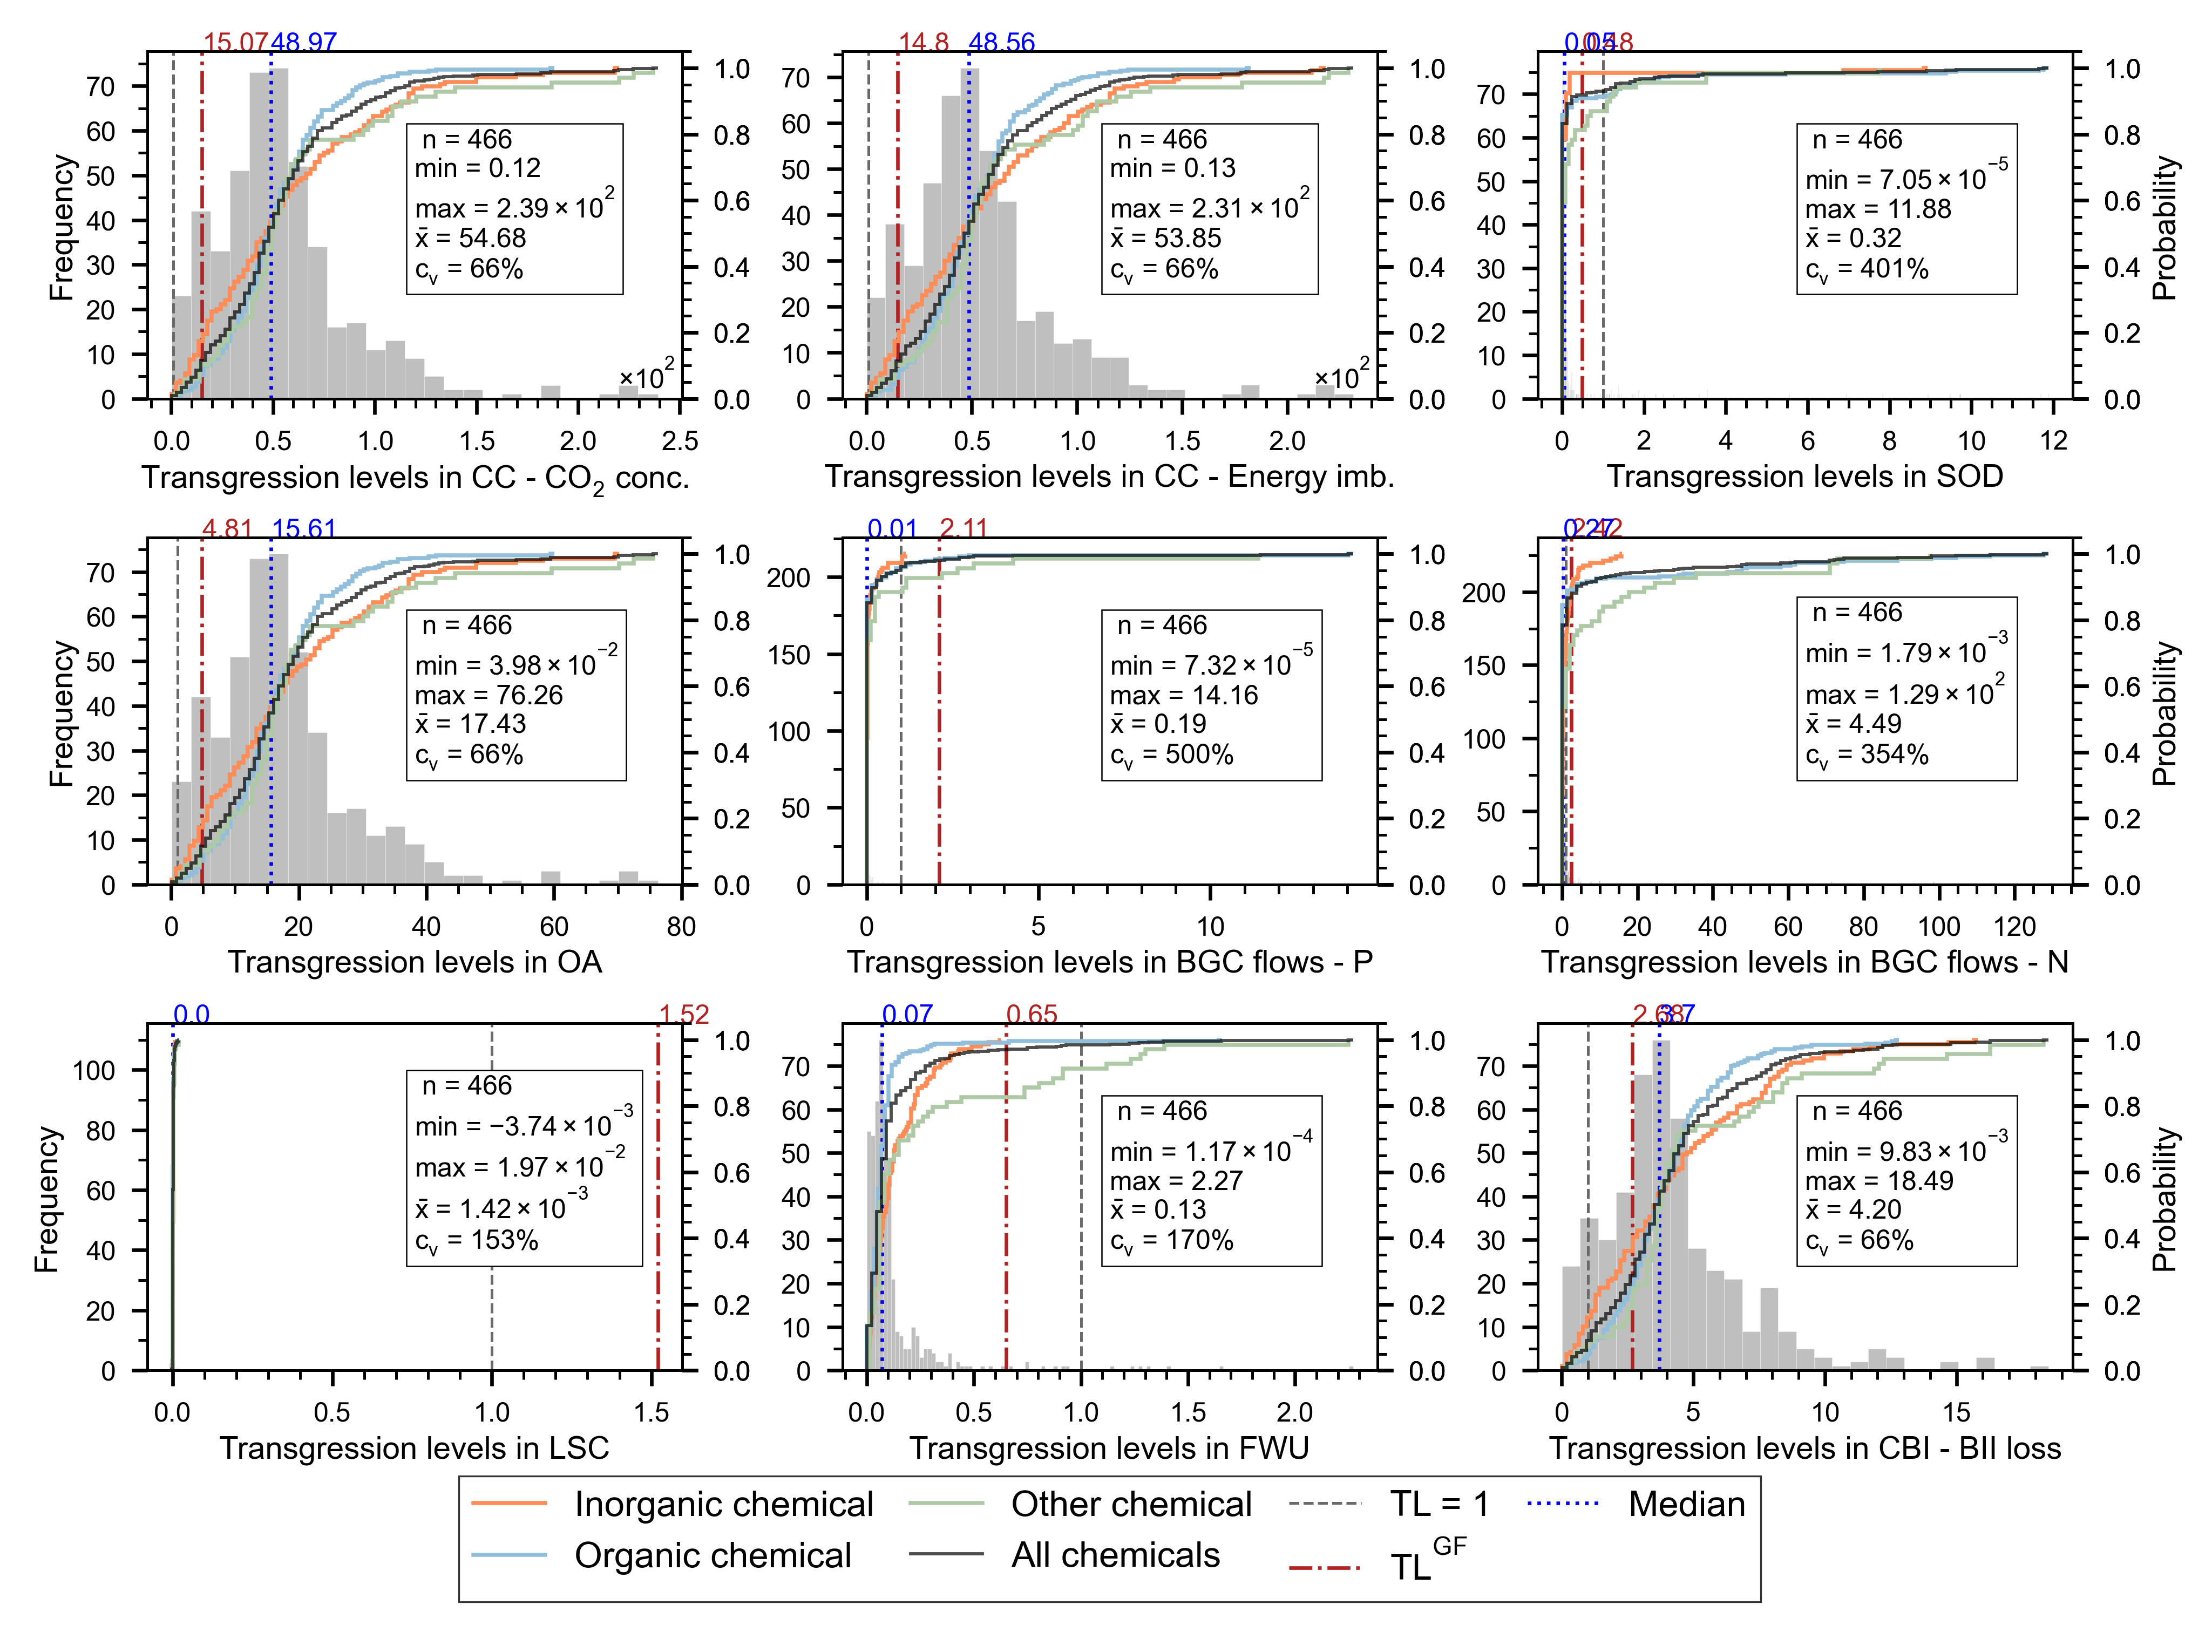

In [11]:
namedf = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods_TLs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

# df_toplot = df_clean_mahalanobis_fig2 # df_cleanxx_prueba2# df_cleanxx_prueba# df_TLs
##################

size_legend_font = 8

fig_width, fig_height = 171, 130
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 10  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 10  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 5  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.86, 0.16],
    #     wspace=0.15,
    hspace=0.005,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)

# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.3,
    hspace=0.4,
)

annotations = []
for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]

    # Remove Nan values
    x_raw = x_raw.astype(np.float64)
    mask = ~np.isnan(x_raw)
    x = x_raw[mask]

    # Subplots ....
    ax = fig.add_subplot(gs[gsx])

    # ---------- histogram ---------------    
    # calculate number of bins
    # credit: https://stats.stackexchange.com/a/862
    # based on Freedman–Diaconis rule (https://www.wikiwand.com/en/Freedman%E2%80%93Diaconis_rule)
    vxmax = max(x)
    vxmin = min(x)
    nsamples = len(x)
    IQR = x.quantile(0.75) - x.quantile(0.25)
    binwidth = 2*IQR/nsamples**(1/3)
    numbins = int((vxmax-vxmin)/binwidth)
    if numbins >= nsamples:
        numbins = "auto"

    ax.hist(
        x,
        bins=numbins,
        cumulative=False,
        histtype="bar",
        color="gray",
        ec="w",
        lw=0.1,
        density=False,
        alpha=0.5,
    )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression levels in " + dict_pbs_plot[cat][0], 50)
    )
    ax.set_xlabel(xlabel=xlabelname, labelpad=2)

    ax.set_ylabel(ylabel="Frequency", labelpad=2)
    if gsx in [1, 2, 4, 5, 7, 8]:
        ax.set_ylabel(None)

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]

        # Remove Nan values
        x_group_raw = x_group_raw.astype(np.float64)
        mask_group = ~np.isnan(x_group_raw)
        x_group = x_group_raw[mask_group]

        # ---------- cumulative histogram ---------------
        ax2 = ax.twinx()
        ax2.hist(
            x_group,
            bins=100,
            cumulative=True,
            histtype="step",
            color=plot_colors[key],
            lw=0.9,
            density=True,
        )
        fix_hist_cdf_drop_line_at_end(ax2)
    ax2.set_ylabel(ylabel="Probability", labelpad=2)
    if gsx in [0, 1, 3, 4, 6, 7]:
        ax2.set_ylabel(None)

    ax2.yaxis.set_major_locator(MultipleLocator(0.2))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(4))

    ax2.hist(
        x,
        bins=100,
        cumulative=True,
        histtype="step",
        color="k",
        lw=0.7,
        alpha=0.7,
        density=True,
    )
    fix_hist_cdf_drop_line_at_end(ax2)

    ax.axvline(
        1, color="dimgray", linestyle="--", linewidth=0.6,
    )
    for k, v in TL_statusquo.items():
        if k in str(cat):
            ax.axvline(
                v,
                color="firebrick",
                linestyle="-.",  # (0, (3, 4, 1, 4, 1, 4)), # loosely dashdotdotted
                linewidth=0.8,
            )

    # --- Format the scale of y axis ---
    if max(ax.get_yticks()) > 150:
        ax.yaxis.set_major_locator(MultipleLocator(50))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    elif max(ax.get_yticks()) > 100:
        ax.yaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    elif max(ax.get_yticks()) > 35:
        ax.yaxis.set_major_locator(MultipleLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    else:
        ax.yaxis.set_major_locator(MultipleLocator(5))
        ax.yaxis.set_minor_locator(AutoMinorLocator(5))

    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax.get_xticks())- min(ax.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax.get_xticks()) > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        formatter.set_powerlimits((-2, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax.get_xaxis().get_offset_text().set_visible(False)
        ax_max = max(ax.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        ax.annotate(
            r"$\times$10$^{%i}$" % (exponent_axis),
            xy=(0.88, 0.03),
            xycoords="axes fraction",
            fontsize=6,
        )
#     elif max(ax.get_xticks()) > 20:
#         ax.xaxis.set_major_locator(MultipleLocator(10))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#     elif max(ax.get_xticks()) > 17:
#         ax.xaxis.set_major_locator(MultipleLocator(5))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
#     elif max(ax.get_xticks()) > 2:
#         ax.xaxis.set_major_locator(MultipleLocator(1))
#         ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    else:
        ax.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))         
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # Activate grid HAY QUE CUADRARLO!
    #     ax.grid(True)
    #     ax.xaxis.grid(True, ls=":", lw=0.3)
    #     ax.yaxis.grid(True, which="major", ls=":", lw=0.3)
    #     ax.set_axisbelow(True)

    # ---------- annotation ----------
    stat_text, dict_stats = calculate_stats(x, excl_power_range=(-1, 2))
    #     print("median:", dict_stats["median_val"])

    #     at = AnchoredText(
    #         stat_text,
    #         prop=dict(size=6),
    #         frameon=True,
    #         loc="upper right",
    #     )
    #     at.patch.set_linewidth(0.5)
    #     at.patch.set_edgecolor("dimgray")
    #     at.patch.set_facecolor("white")
    #     ax.add_artist(at)

    ax.text(
        0.5,
        0.35,
        stat_text,
        fontsize=6,
        bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        transform=ax.transAxes,
    )
    # ----------- vertial line for median ---------------
    ax.axvline(
        dict_stats["median_val"], color="blue", linestyle="dotted", linewidth=0.8,
    )

    axvlines_coord = dict()
    for k, v in TL_statusquo.items():
        if k in str(cat):
            axvlines_coord[v] = (np.round(v, 2), 
                                 "firebrick") # coordinate, value, color for TL_statusquo vline
    axvlines_coord[dict_stats["median_val"]] = (np.round(dict_stats["median_val"], 2), 
                                                "blue") # coordinate, value, color for Median vline

#     print(axvlines_coord)
    _, y_maxval = ax.get_ylim()
    for annot_coordinate, (annot_val, annot_color) in axvlines_coord.items():
        annotate_axvlines = ax.text(
            annot_coordinate,
            y_maxval,
            annot_val,
            fontsize=6,
            c=annot_color,
#             bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        )
        annotations.append(annotate_axvlines)

# adjust text automatically (for now not working, adjust manually in postproduction...)
# adjust_text(
#     annotations,
# #     xycoords="data",
# #     arrowprops=dict(
# #         arrowstyle="-|>, head_length=0.3, head_width=0.15", color="k", linewidth=0.3,
# #     ),
#     text_from_points=False,
#     autoalign="y",
#     force_points=(0.002, 0.005),
# )

# Legend
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

for key, group in grouped.items():
    ax.plot([], [], color=plot_colors[key], label=key, linestyle="-", lw=0.9)
ax.plot([], [], color="k", linestyle="-", linewidth=0.7, alpha=0.7, label="All chemicals")
ax.plot([], [], color="dimgray", linestyle="--", linewidth=0.6, label="TL = 1",)
ax.plot([], [], color="firebrick", linestyle="-.", linewidth=0.8, label="$TL^{GF}$",) # label="Grandfathering TL"
ax.plot([], [], color="blue", linestyle="dotted", linewidth=0.8, label="Median")

handles, labels = ax.get_legend_handles_labels()

leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.5, 0.0),
    ncol=4,
    fontsize=size_legend_font,
    fancybox=False,
    columnspacing=1,
    #     labelspacing=0.5,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

# # EXPORT FIGURE
# figNamePNG = "Fig2_{}.png".format(namedf)
# figNameSVG = "Fig2_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [12]:
# # NEGATIVE TRANSGRESSION LEVELS FOR FWU

# neg_FWU_ids = []
# for idx in df_toplot[lst_methods_TLs[7]].index:
#     if df_toplot.loc[idx, lst_methods_TLs[7]] < 0:
#         neg_FWU_ids.append(idx)
# df_toplot.loc[neg_FWU_ids][["Activity", lst_methods_TLs[7]]]

In [13]:
# # NEGATIVE TRANSGRESSION LEVELS FOR LSC

# neg_LSC_ids = []
# for idx in df_toplot[lst_methods_TLs[6]].index:
#     if df_toplot.loc[idx, lst_methods_TLs[6]] < 0:
#         neg_LSC_ids.append(idx)
# df_toplot.loc[neg_LSC_ids][["Activity", lst_methods_TLs[6]]].sort_values(
#     by="TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"
# ) # .Activity.tolist()

### fig 3 (previously fig1, + new modified plot)
<div class="alert alert-block alert-info">
  Bivariate analysis: <br>
    GWP vs TLs of the PBs method categories <br>
    and <br>
    GWP vs categories of PBs method<br>
    - scatter plots  <br>
    - histograms  <br>
    - rug plots  <br>
</div>

#### Fig3 (no subplots)

#### Fig3 ver1

r_spearman is 0.12
r_pearson is 0.14
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.14
r_pearson is 0.16
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.16
r_pearson is 0.08
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.12
r_pearson is 0.14
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.11
r_pearson is -0.02
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.2
r_pearson is -0.02
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.9200000000

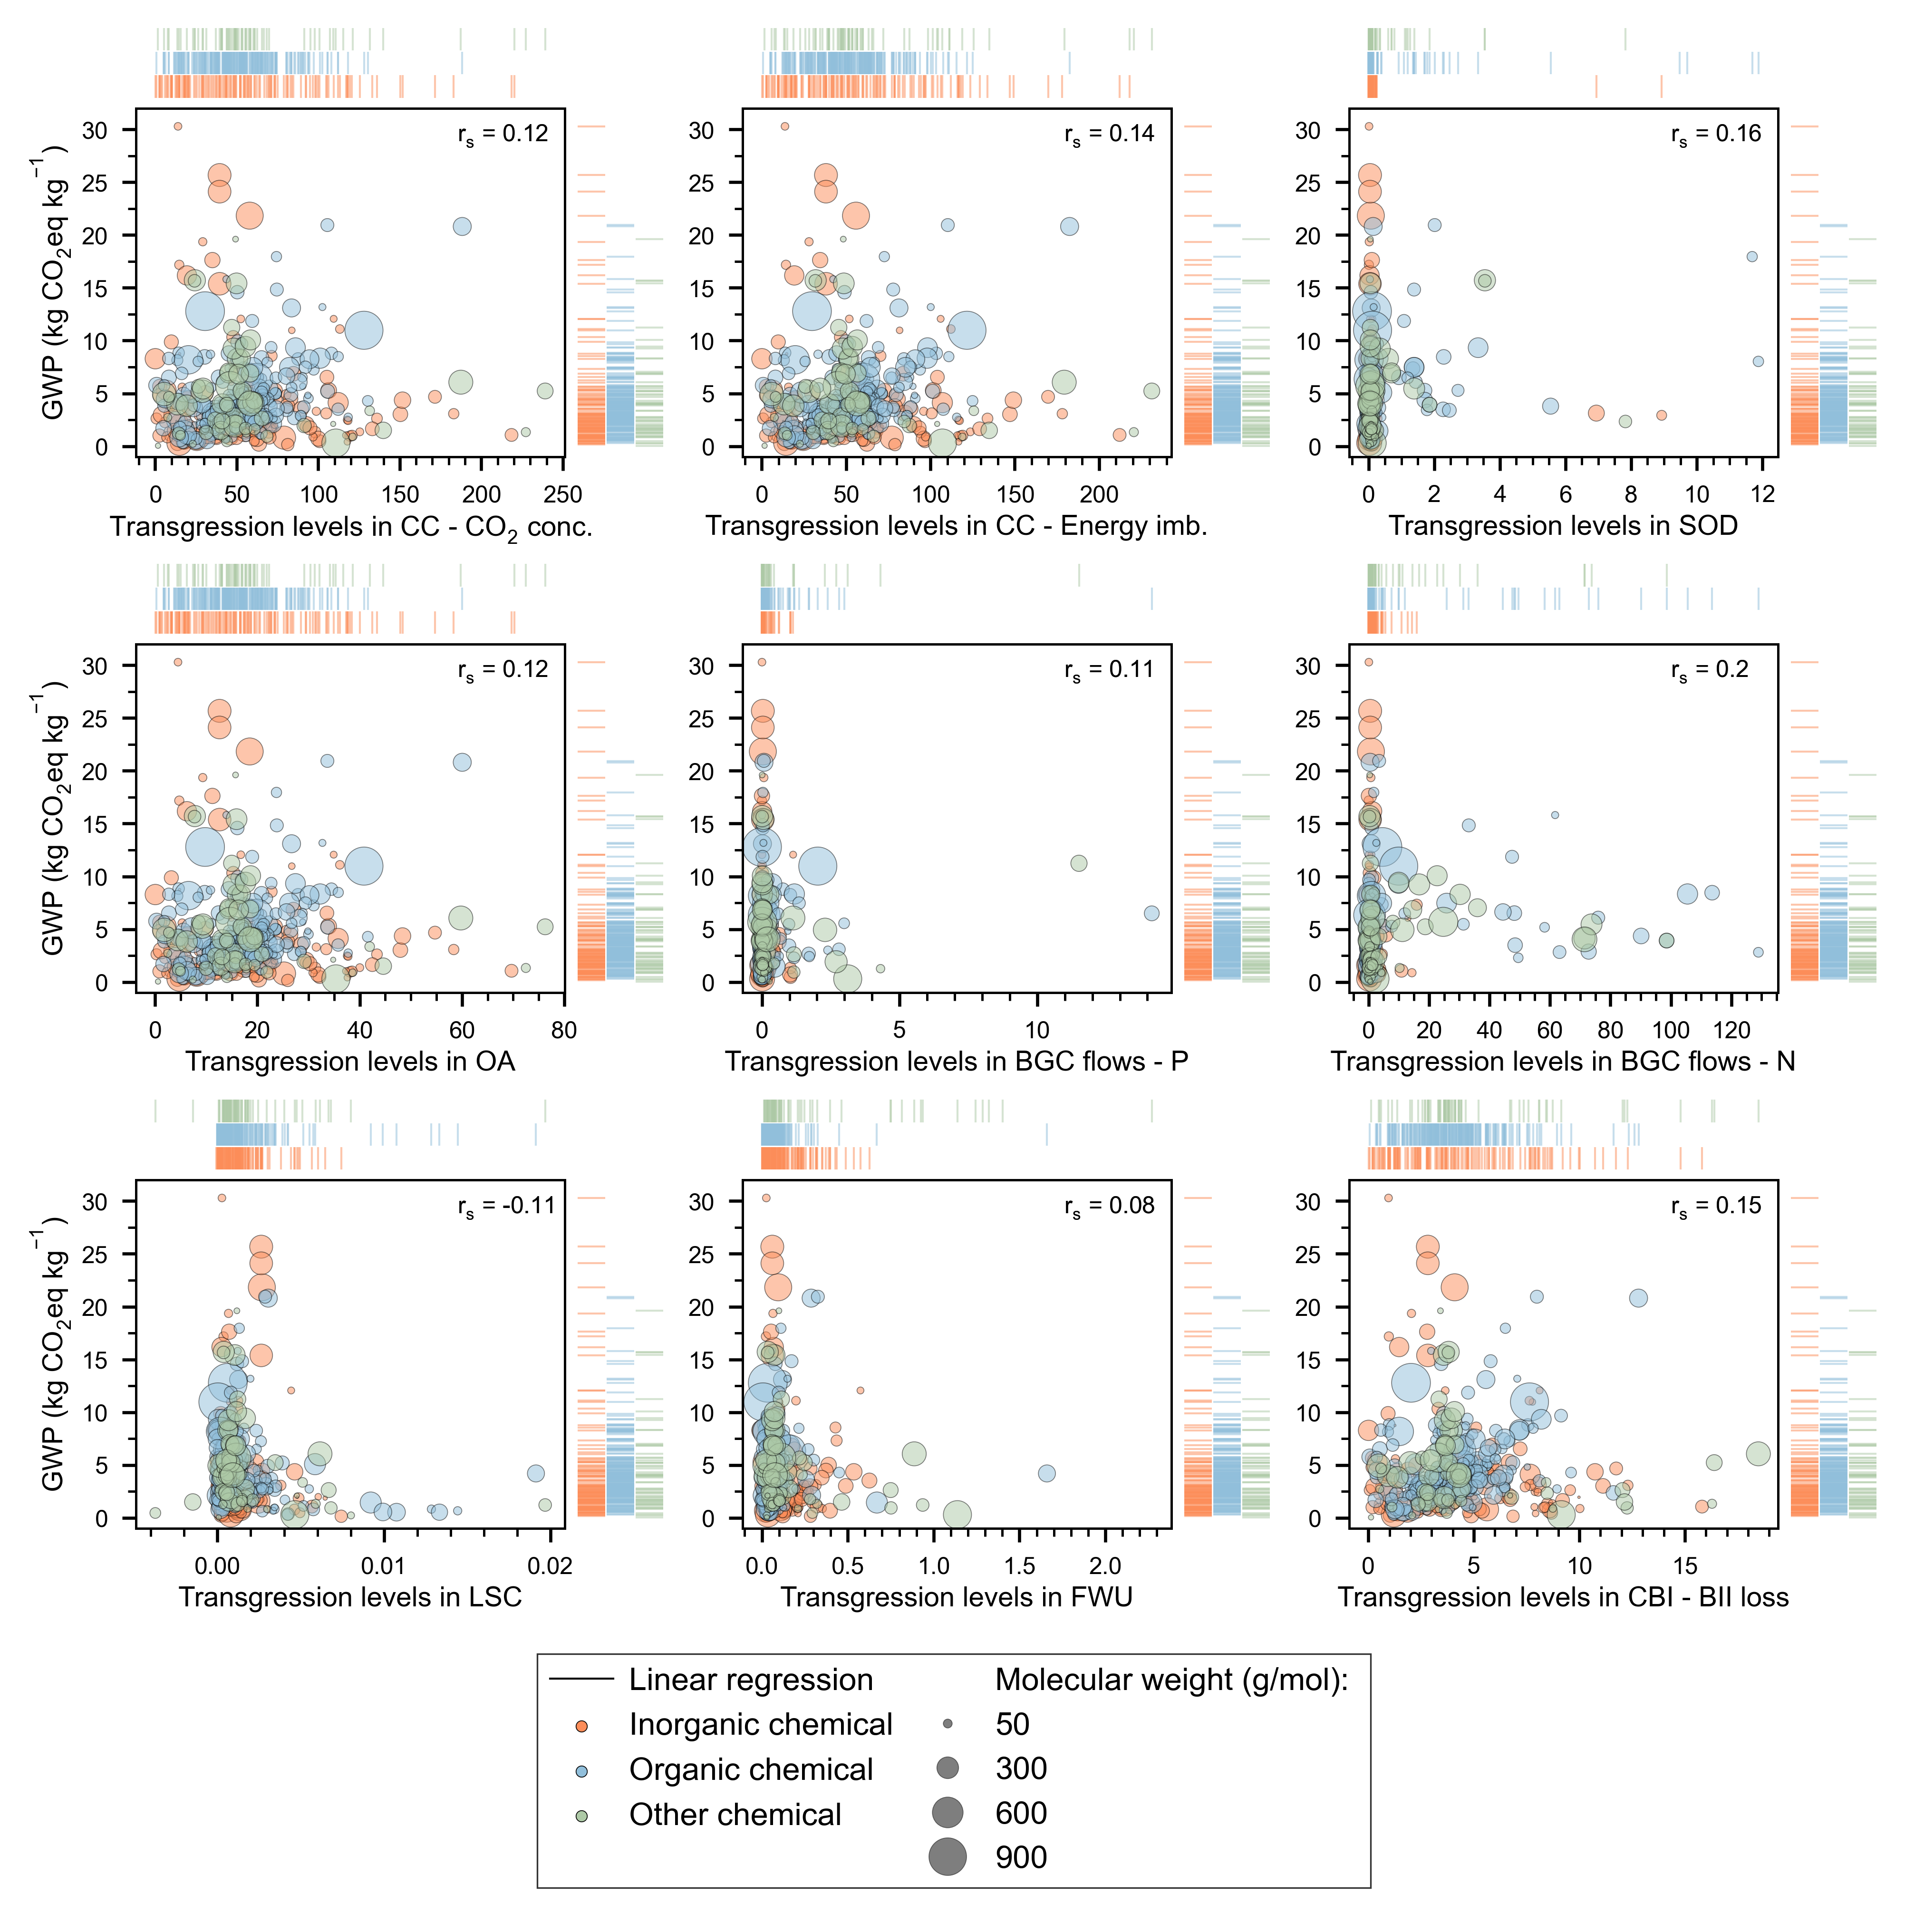

In [61]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods_TLs

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################


size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 171
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.1,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.15,
    hspace=0.25,
)


for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
#     y = np.log(y_raw[mask])  # !!! CHANGEd DUE TO set_yscale("log")

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)
    
    # Spearman's rank correlation coefficient
    # assesses monotonic relationships between variables
    r_spearman = x.corr(y, method='spearman').round(2)
    r_spearman_text = "$r_{s}$ = " + str(r_spearman)

    # Pearson correlation coefficient
    # assesses linear relationships between variables
    r_pearson = x.corr(y, method='pearson').round(2)
    
    print("r_spearman is {}\nr_pearson is {}".format(r_spearman, r_pearson))

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
#         width_ratios=[1.5, 1],
        width_ratios=[1.5, 0.3],
        wspace=0.05,
#         height_ratios=[1, 1.5],
        height_ratios=[0.3, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
#         nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
        nrows=3, ncols=1, height_ratios=[0.5, 0.5, 0.5], hspace=0.05,        
    )
    ax_4 = gs_PB[3].subgridspec(
#         nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
        nrows=1, ncols=3, width_ratios=[0.5, 0.5, 0.5], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
#     ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
#     ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
#     stat_text = calculate_stats(x)
#     #     stat_of_GWP = calculate_stats(y)
#     #     pprint.pprint(stat_of_GWP)
#     ax_2.text(
#         0.15,
#         0.3,
#         stat_text,
#         fontsize=5.5,
#         linespacing=1,
#         va="bottom",
#         ha="left",
#         multialignment="left",
#         bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
#         # frameon=True, # prop=dict(size=6),  #loc="center",
#     )
#     #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
#     ax_2.annotate(
#         "",
#         xy=(0.14, 0.7),
#         xycoords="axes fraction",
#         xytext=(-0.1, 0.7),
#         arrowprops=dict(
#             arrowstyle="<|-, head_length=0.3, head_width=0.15",
#             color="k",
#             linewidth=0.3,
#         ),
#     )
    ax_2.axis("off")

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)
        # ---------- regression line ---------------
#         ax_3.plot(
#             X, Y_pred, color="black", lw=0.5,
#         )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        ##### replace Rsquare with r_spearman
#         if namedf  == "df_base_full_wCAS_woOutliersRMDk9a5":
#             if gsx == 7:
#                 xposR2 = 0.7
#             else:
#                 xposR2 = 0.55
#         else:
#             xposR2 = 0.6  # 0.02
        xposR2 = 0.75
        yposR2 = 0.92

        ax_3.text(
            xposR2,
            yposR2,
#             Rsquare,
            r_spearman_text,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
#         ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i-1], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~######################## ax_3 axes ######  
    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)
#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs_plot[cat][0] + " (" + dict_pbs_plot[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap("Transgression levels in " + dict_pbs_plot[cat][0], 50)
    )

#         ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)
    ax_3.set_xlabel(xlabel=xlabelname, labelpad=2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        # ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)
#         ax_3.set_yscale('log')
    
    # Y axis limit
    ax_3.set_ylim(top=32)
    ax_3.set_ylim(bottom=-1)
    ax_3.yaxis.set_major_locator(MultipleLocator(5))
    ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.01: 5, 0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax_3.get_xticks())- min(ax_3.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax_3.get_xticks()) > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -2  # -1
        max_exp = 3  # 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax_3.xaxis.set_major_formatter(formatter)
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax_3.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax_3.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax_3.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                #             xy=(0.76, 0.02),
                xy=(1.001, -0.08),
                xycoords="axes fraction",
                fontsize=6,
            )
    else:
        ax_3.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))   
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

#     # ---------- histogram top ---------------
#     ax_1_hist.hist(x, bins=50, color="grey")
#     #     ax_1_hist.set_xticks([])  # next 2 lines do this
#     ax_1_hist.tick_params(labelbottom=False)
#     #     ax_1_hist.tick_params(axis='x', which='both', length=0)
#     ax_1_hist.spines["top"].set_visible(False)
#     #     ax_1_hist.spines['left'].set_visible(False)
#     ax_1_hist.spines["right"].set_visible(False)
#     #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
#     #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
#     ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # ---------- histogram right ---------------
#     ax_4_hist.hist(y, bins=50, orientation="horizontal", color="grey")
#     #     ax_4_hist.set_yticks([]) # next 2 lines do this
#     ax_4_hist.tick_params(labelleft=False)
#     #     ax_4_hist.tick_params(axis='y', which='both', length=0)
#     ax_4_hist.xaxis.tick_top()
#     #     ax_4_hist.spines['top'].set_visible(False)
#     ax_4_hist.spines["bottom"].set_visible(False)
#     ax_4_hist.spines["right"].set_visible(False)
#     #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
#     #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
#     ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig3_{}.png".format(namedf)
# figNameSVG = "Fig3_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [15]:
# df_toplot.referenceProduct_price.max()

In [164]:
# LIST OF CHEMICALS NOT SHOWN ON FIG3 DUE TO HIGH GWP SCORES...
# this list or graphical representation will be shown in ESI?

df_not_on_fig3 = df_base_full_wCAS_woOutliersRMDk9a5[
    df_base_full_wCAS_woOutliersRMDk9a5[lst_methods[0]] > 32
].sort_values(by="('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')")[
    lst_metadata[0:1]
    + lst_metadata[4:5]
#     + ["referenceProduct_price"]
    + lst_methods[0:1]
    + lst_methods_TLs
]  # .shape

# df_not_on_fig3

In [149]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "list-chemicals-not-shown-on-fig3.xlsx"

df_readme = make_readme_info(
    excelName,
    "Sheet1: Dataframe of chemicals excluded from Fig3 with their GWP and TLs scores"
    "\n[none of the chemicals in the list were detected as outliers, but"
    " were omitted from Fig3 for visualisation purposes]",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_not_on_fig3,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: list-chemicals-not-shown-on-fig3.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-LCIA_methods_analysis\data\interim
Wall time: 601 ms


#### Fig3 ver2

In [62]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS" # TAKES A LOT TO PLOT...
loop_methods = lst_methods[1:]

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################
print("Used df: ", namedf)

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 180
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.05,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.20,
    hspace=0.25,
)

for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
        width_ratios=[1.5, 1],
        wspace=0.05,
        height_ratios=[1, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
        nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
    )
    ax_4 = gs_PB[3].subgridspec(
        nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
    ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
    ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
    stat_text = calculate_stats(x)
    #     stat_of_GWP = calculate_stats(y)
    #     pprint.pprint(stat_of_GWP)
    ax_2.text(
        0.15,
        0.3,
        stat_text,
        fontsize=5.5,
        linespacing=1,
        va="bottom",
        ha="left",
        multialignment="left",
        bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
        # frameon=True, # prop=dict(size=6),  #loc="center",
    )
    #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
    ax_2.annotate(
        "",
        xy=(0.14, 0.7),
        xycoords="axes fraction",
        xytext=(-0.1, 0.7),
        arrowprops=dict(
            arrowstyle="<|-, head_length=0.3, head_width=0.15",
            color="k",
            linewidth=0.3,
        ),
    )
    ax_2.axis("off")

    grouped = dict(list(df_toplot.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)

        #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
        ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)

        xlabelname = "\n".join(
            textwrap.wrap(dict_pbs[cat][0] + " (" + dict_pbs[cat][1] + ")", 50)
        )
        ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)

        xlim_ax3 = ax_3.get_xlim()
        ylim_ax3 = ax_3.get_ylim()

        if gsx in [1, 2, 4, 5, 7, 8]:
            #             ax_3.set_yticks([])
            ax_3.set_ylabel(None)
        #         ax_3.get_yaxis().set_visible(False)
        #     ax_3.grid(True)

#         ax_3.yaxis.set_major_locator(MultipleLocator(10))
        ax_3.yaxis.set_minor_locator(AutoMinorLocator(5))
        #         ax_3.xaxis.set_major_locator(MultipleLocator(1))
#         ax_3.set_yscale("log") ?????????????
#         ax_3.set_xscale("log") ?????????????
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(2))

        # ---------- regression line ---------------
        ax_3.plot(
            X, Y_pred, color="black", lw=0.5,
        )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        xposR2 = 0.02
        yposR2 = 0.92
#         if gsx in [2]:
#             xposR2 = 0.5       
#         if gsx in [4]:
#             xposR2 = 0.44
#         if gsx in [5, 6]:
#             xposR2 = 0.65           
#         if gsx in [7]:
#             xposR2 = 0.15

        ax_3.text(
            xposR2,
            yposR2,
            Rsquare,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    formatter = ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    min_exp = -1
    max_exp = 1
    formatter.set_powerlimits((min_exp, max_exp))
    ax_3.xaxis.set_major_formatter(formatter)
    # ~~~~ move the formatter inside the axes box
    ## from https://stackoverflow.com/a/59018067/14485040
    ax_3.get_xaxis().get_offset_text().set_visible(
        False
    )  # .set_position((1.1,0)) # only moves on its x-axis
    ax_max = max(ax_3.get_xticks())
    exponent_axis = np.floor(np.log10(ax_max)).astype(int)
    if exponent_axis <= min_exp or exponent_axis >= max_exp:
        ax_3.annotate(
            r"$\times$10$^{%i}$" % (exponent_axis),
            #             xy=(0.76, 0.02),
            xy=(1.001, -0.08),
            xycoords="axes fraction",
            fontsize=6,
        )
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # ---------- histogram top ---------------
    ax_1_hist.hist(x, 
#                    bins="auto", 
                   bins=120,
                   color="grey")
    #     ax_1_hist.set_xticks([])  # next 2 lines do this
    ax_1_hist.tick_params(labelbottom=False)
    #     ax_1_hist.tick_params(axis='x', which='both', length=0)
    ax_1_hist.spines["top"].set_visible(False)
    #     ax_1_hist.spines['left'].set_visible(False)
    ax_1_hist.spines["right"].set_visible(False)
    #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
    #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
    ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

    # ---------- histogram right ---------------
    ax_4_hist.hist(y, 
#                    bins="auto", 
                   bins=120,
                   orientation="horizontal", color="grey")
    #     ax_4_hist.set_yticks([]) # next 2 lines do this
    ax_4_hist.tick_params(labelleft=False)
    #     ax_4_hist.tick_params(axis='y', which='both', length=0)
    ax_4_hist.xaxis.tick_top()
    #     ax_4_hist.spines['top'].set_visible(False)
    ax_4_hist.spines["bottom"].set_visible(False)
    ax_4_hist.spines["right"].set_visible(False)
    #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
    #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
    ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
# figNamePNG = "Fig3_GWPvsPBs_{}.png".format(namedf)
# figNameSVG = "Fig3_GWPvsPBs_{}.svg".format(namedf)

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

Used df:  df_base_full_wCAS_woOutliersRMDk9a5
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.110

ValueError: 
1.17\\times 10^{-12}
    ^
Unknown symbol: \, found '\'  (at char 4), (line:1, col:5)

<Figure size 4039.37x4251.97 with 91 Axes>

In [16]:
# df_toplot[df_toplot[lst_methods[0]]>20]

#### One by one -- temporal

### fig 4 (NEW heatmap)
<div class="alert alert-block alert-info">
  Heatmap of highlighted chemicals. Show in columns: <br>
    - GWP  <br>
    - Transgression level of PBs <br>
    - Price <br>
</div>

In [121]:
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib.ticker import NullFormatter, StrMethodFormatter, LogLocator, ScalarFormatter

In [122]:
class MidPointLogNorm(LogNorm):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        LogNorm.__init__(self,vmin=vmin, vmax=vmax, clip=clip)
        self.midpoint=midpoint
    def __call__(self, value, clip=None):
        result, is_scalar = self.process_value(value)
        x, y = [np.log(self.vmin), np.log(self.midpoint), np.log(self.vmax)], [0, 0.5, 1]
        return np.ma.array(np.interp(np.log(value), x, y), mask=result.mask, copy=False)

#### ** functions

In [123]:
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """Annotate a heatmap.
    
    Taken from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
#             kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            if data[i, j] < 0.01: # for values almost 0.00
#                 print(data[i, j])
#                 less_decimals = "{x:.0f}"
#                 less_decimals = mpl.ticker.StrMethodFormatter(less_decimals)
#                 value_formatted = less_decimals(data[i, j], None)
                value_formatted = r"$\approx$ 0"
            elif data[i, j] >= 10.00: # for values greater than 10, show 1 decimal
#                 print(data[i, j])
                less_decimals = "{x:.1f}"
                less_decimals = mpl.ticker.StrMethodFormatter(less_decimals)
                value_formatted = less_decimals(data[i, j], None)
            else:
                value_formatted = valfmt(data[i, j], None)
            text = im.axes.text(j, i, value_formatted, **kw)
            texts.append(text)

    return texts

In [124]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """Create a heatmap from a numpy array and two lists of labels.
    
    Modified from https://matplotlib.org/3.1.1/gallery/images_contours_and_fields/image_annotated_heatmap.html

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

#     # Create colorbar
#     cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks... ---> ticks must be created to be able to plot the data
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im#, cbar

In [126]:
def make_sequential_color_palette(min_value_hue: str, max_value_hue: str, N: 256 = int):
    """Make color palettes from two HEX colors which should be provided as extremes.
    
    Colors can be taken from: 
        1. Inkscape, 
        2. https://learnui.design/tools/data-color-picker.html
        3. https://vis4.net/palettes/#/8|s|00429d,96ffea,ffffe0|ffffe0,ff005e,93003a|1|1
    
    Parameters
    ----------
    min_value_hue
        Color value in HEX format, e.g. #003f5c    
    max_value_hue
        Color value in HEX format, e.g. #003f5c
    N
        Number of colors
    """
    color_min = mpl.colors.to_rgba(min_value_hue)
    color_max = mpl.colors.to_rgba(max_value_hue)

    vals = np.ones((N, 4))
    vals[:, 0] = np.linspace(color_min[0], color_max[0], N)
    vals[:, 1] = np.linspace(color_min[1], color_max[1], N)
    vals[:, 2] = np.linspace(color_min[2], color_max[2], N)
    cmap = mpl.colors.ListedColormap(vals)

    # Visualize the same pallete with less colors
    n = 16
    vals_visual = np.ones((n, 4))
    vals_visual[:, 0] = np.linspace(color_min[0], color_max[0], n)
    vals_visual[:, 1] = np.linspace(color_min[1], color_max[1], n)
    vals_visual[:, 2] = np.linspace(color_min[2], color_max[2], n)
    palette_plot = sns.palplot(vals_visual)
    #     print("Visualization of the full sequential palette, for {} colors:\n".format(n))

    return cmap


def make_diverging_color_palette(
    min_value_hue: str, max_value_hue: str, lowest_min_value_hue="#ffffff", lowest_max_value_hue="#ffffff", N: 256 = int
):
    """
    default mid_valye_hue = "#ffffff" -> white
    
    """

    min_hue = min_value_hue
    l_min_hue = lowest_min_value_hue
    l_max_hue = lowest_max_value_hue
#     mid_hue = mid_value_hue
    max_hue = max_value_hue

    left_palette = make_sequential_color_palette(min_hue, l_min_hue, N=N)
    right_palette = make_sequential_color_palette(l_max_hue, max_hue, N=N)

    vals = np.vstack(
        (
            left_palette(np.linspace(0, 1, int(N / 2))),
            right_palette(np.linspace(0, 1, int(N / 2))),
        )
    )
    cmap = mpl.colors.ListedColormap(vals)

    # Visualize the same pallete with less colors
    n = 8
    vals_visual = np.vstack(
        (left_palette(np.linspace(0, 1, n)), right_palette(np.linspace(0, 1, n)))
    )
    palette_plot = sns.palplot(vals_visual)

    print(
        "Visualization of the parts of the palette and full palette, for {} colors:\n".format(
            n*2
        )
    )
    print("1. Left half\n2. Right half\n3. Full diverging palette\n")

    return cmap

#### pretreatment

##### Generate colors for heatmap

Visualization of the parts of the palette and full palette, for 16 colors:

1. Left half
2. Right half
3. Full diverging palette



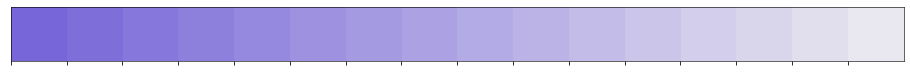

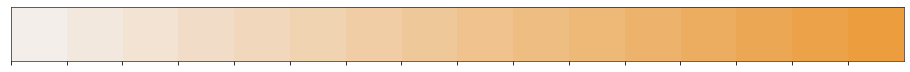

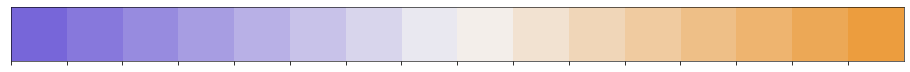

In [127]:
cmap_left = make_diverging_color_palette(
    min_value_hue="#7766d9ff",# "#7861a4", 
    max_value_hue="#ec9d3e", # "#6c7d37ff",
    lowest_min_value_hue="#e9e8f0ff",
    lowest_max_value_hue="#f3eeea", # "#e7ebdaff",
    N=256,
)

Visualization of the parts of the palette and full palette, for 16 colors:

1. Left half
2. Right half
3. Full diverging palette



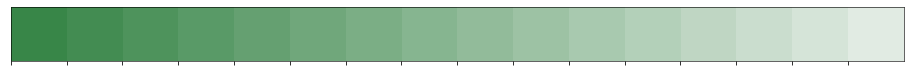

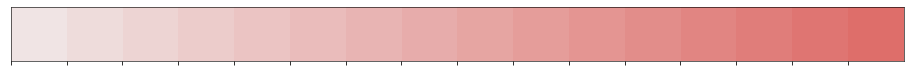

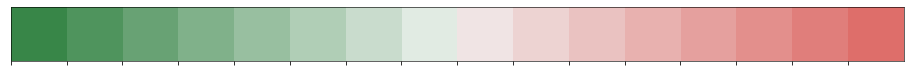

In [128]:
# cmap_center = make_diverging_color_palette(min_value_hue="#398649ff", max_value_hue="#d73e39ff", mid_value_hue="#ece7e4ff", N=256)
cmap_center = make_diverging_color_palette(
    min_value_hue="#388648ff",
    max_value_hue="#de6e6aff", # "#d73e39ff",
    lowest_min_value_hue="#e1ebe3ff",
    lowest_max_value_hue="#f0e4e4ff",
    N=256,
)

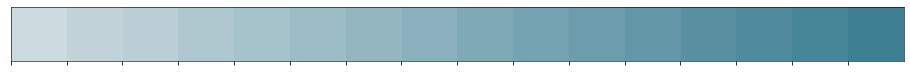

In [129]:
cmap_right = make_sequential_color_palette(
    min_value_hue="#ccdbe0ff", 
    max_value_hue="#3e7f93ff", 
    N=256
)

##### create df to plot

In [130]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5" # the same as df_base_full_wCAS_woOutliersMDk20a5
# namedf = "df_base_full_wCAS"

# pd.eval(namedf).sort_values(
#     by="TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
# )["TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"].max()

# highlighted_product
df_heatmap_raw = pd.eval(namedf)[
    pd.eval(namedf).referenceProduct.isin(highlighted_product)
][
    [
        "referenceProduct",
        "referenceProduct_price",
        "referenceProduct_priceUnit",
        "referenceProduct_priceComment",
    ]
    + lst_methods
    + lst_methods_TLs
]

num_outliers_on_heatmap = len(highlighted_product) - df_heatmap_raw.shape[0]
print(
    "The list of selected products has {} items, the heatmap will show {}."
    "\n\t{} items are outliers (should go in gray, postproduction)".format(
        len(highlighted_product),
        df_heatmap_raw.shape[0],
        num_outliers_on_heatmap,
    )
)

df_heatmap_raw.head(2)

The list of selected products has 34 items, the heatmap will show 32.
	2 items are outliers (should go in gray, postproduction)


referenceProduct  referenceProduct_price referenceProduct_priceUnit  \
3        1-propanol                1.191194                    USD2018   
23     Acetaldehyde                1.162491                    USD2018   

                        referenceProduct_priceComment  \
3   Calculated value based on data from United Nat...   
23                 Assumed to be equal to RER prices.   

    ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
3                                            4.525119            
23                                           1.845922            

    ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
3                                        1.092401e-10                            
23                                       4.244220e-11                            

    ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
3                                        1.469075e-12                            
23                                       5.700416e-13                            

    ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
3                                        1.681898e-14                      
23                                       3.948910e-15                      

    ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
3                                        3.338089e-13                      
23                                       1.296921e-13                      

    ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
3                                        1.208436e-15                   
23                                       4.537303e-16                   

    ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')  \
3                                        2.615136e-13                   
23                                       9.525698e-14                   

    ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')  \
3                                        9.806755e-16                   
23                                       1.041575e-16                   

    ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')  \
3                                        8.069268e-12                 
23                                       3.748669e-12                 

    ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')  \
3                                        1.095162e-12                                         
23                                       4.262741e-13                                         

    TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
3                                           93.998992                                  
23                                          37.422453                                  

    TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
3                                           91.015966                                  
23                                          36.188733                                  

    TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
3                                            0.071863                            
23                                           0.017289                            

    TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
3                                           29.972474                            
23                                          11.932494                            

    TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')  \
3                                            0.007562                         
23                                           0.002910                         

    TL in ('PBs-LCIA (baseline) V0.

In [131]:
# convert prices from EUR2005 to USD2018 (IT HAS BEEN IMPLEMENTED AT df_base_full LEVEL)
# using this unit the TLs were calculated !!!
if all(df_heatmap_raw.referenceProduct_priceUnit == "EUR2005"):
    PPI_2018 = 104.5 # Producer Price Index from Eurostat
    PPI_2005 = 86.0  # Producer Price Index from Eurostat
    USD_per_EUR_2018 = 1.1811 # average exchange rate EUR to USD in 2018

    df_heatmap_raw.referenceProduct_price = (df_heatmap_raw.referenceProduct_price * PPI_2018 / PPI_2005) * USD_per_EUR_2018
    df_heatmap_raw.referenceProduct_priceUnit = "USD2018"
    df_heatmap_raw.head(2)

In [132]:
# Update names of PBs and GWP
rename_methods = {
    "('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')": "Carbon footprint",
    "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": "Climate change - CO2 concentration",
    "('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": "Climate change - Energy imbalance",
    "('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": "Stratospheric ozone depletion",
    "('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": "Ocean acidification",
    "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": "Biogeochemical flows - Phosphorus",
    "('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": "Biogeochemical flows - Nitrogen",
    "('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": "Land-system change",
    "('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": "Freshwater use",
    "('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": "Biosphere integrity",

    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')": "TL in Climate change - CO2 concentration",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')": "TL in Climate change - Energy imbalance",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')": "TL in Stratospheric ozone depletion",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')": "TL in Ocean acidification",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')": "TL in Biogeochemical flows - Phosphorus",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')": "TL in Biogeochemical flows - Nitrogen",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')": "TL in Land-system change",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')": "TL in Freshwater use",
    "TL in ('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')": "TL in Biosphere integrity",
    
    "referenceProduct_price": "Price",
}

df_heatmap_raw = df_heatmap_raw.rename(columns=rename_methods)
# df_heatmap_raw

In [344]:
# read the price comments

# for i in df_heatmap_raw.index:
#     if df_heatmap_raw.referenceProduct_priceComment[i] != None:
#         print(
#             "\n\t",
#             df_heatmap_raw.referenceProduct[i],
#             "\n",
#             df_heatmap_raw.referenceProduct_priceComment[i],
#         )

In [133]:
# Create df to plot and sort by values in speficied column

df_plot = df_heatmap_raw.set_index("referenceProduct").sort_values(
#     by="Carbon footprint"
    by="TL in Climate change - Energy imbalance"
#     by="Climate change - Energy imbalance"
#     by="Climate change - CO2 concentration"
)
# df_plot

In [346]:
# df_plot.index

In [134]:
# update column names to show subindices if any
dict_updated_colnames = {}
for colname in df_plot.columns: 
    if "CO2" in colname:
        newname = colname.replace("CO2", "$CO_2$" )
        dict_updated_colnames[colname] = newname
    else:
        dict_updated_colnames[colname] = colname
dict_updated_colnames
df_plot = df_plot.rename(columns=dict_updated_colnames)

# update index names to make them shorter
dict_updated_idxnames = {}
for idxname in df_plot.index: 
    if idxname == "Acetic acid, without water, in 98% solution state":
        newname = "Acetic acid, w/o water"
        dict_updated_idxnames[idxname] = newname
    else:
        dict_updated_idxnames[idxname] = idxname
dict_updated_idxnames
df_plot = df_plot.rename(index=dict_updated_idxnames)
df_plot = df_plot.loc[:,~df_plot.columns.duplicated()]
df_plot.index

Index(['Hydrogen, liquid', 'Pyridine', 'Xylene', 'Petrol, low-sulfur',
       'Diesel, low-sulfur', 'Ethylene, average',
       'Polyvinylchloride, bulk polymerised', 'Propylene', 'Kerosene',
       'Acetaldehyde', 'Ethylene oxide', 'Liquefied petroleum gas', 'Methanol',
       'Polyethylene, high density, granulate', 'Polypropylene, granulate',
       'Glyphosate', 'Toluene, liquid', 'Chlorotoluron', 'Benzene',
       'Fluorine, liquid', 'Acetic acid, w/o water', 'Para-phenylene diamine',
       'Formaldehyde', 'Methylene diphenyl diisocyanate', 'Acrylonitrile',
       'Sulfuric acid', 'Acetylene', '1-propanol', 'Nylon 6-6',
       'Ammonia, liquid', 'Chlorine, liquid', 'Urea, as N'],
      dtype='object', name='referenceProduct')

In [244]:
# remove extremely transgressed chemical ?
# df_plot = df_plot[df_plot.index != "Ammonium nitrate, as N"]

In [135]:
shorter_methods = {
    "Carbon footprint": "GWP",
    "TL in Climate change - $CO_2$ concentration": "CC - $CO_2$ conc.",
    "TL in Climate change - Energy imbalance": "CC - Energy imb.",
    "TL in Stratospheric ozone depletion": "SOD",
    "TL in Ocean acidification": "OA",
    "TL in Biogeochemical flows - Phosphorus": "BGC flows - P",
    "TL in Biogeochemical flows - Nitrogen": "BGC flows - N",
    "TL in Land-system change": "LSC",
    "TL in Freshwater use": "FWU",
    "TL in Biosphere integrity": "CBI - BII loss",
    "referenceProduct_price": "Price",
}

df_plot = df_plot.rename(columns=shorter_methods)

#### plotting

Used df:  df_base_full_wCAS_woOutliersRMDk9a5
Size of the figure:
Specified height is 208 mm 
Calculated width is 135.0 mm


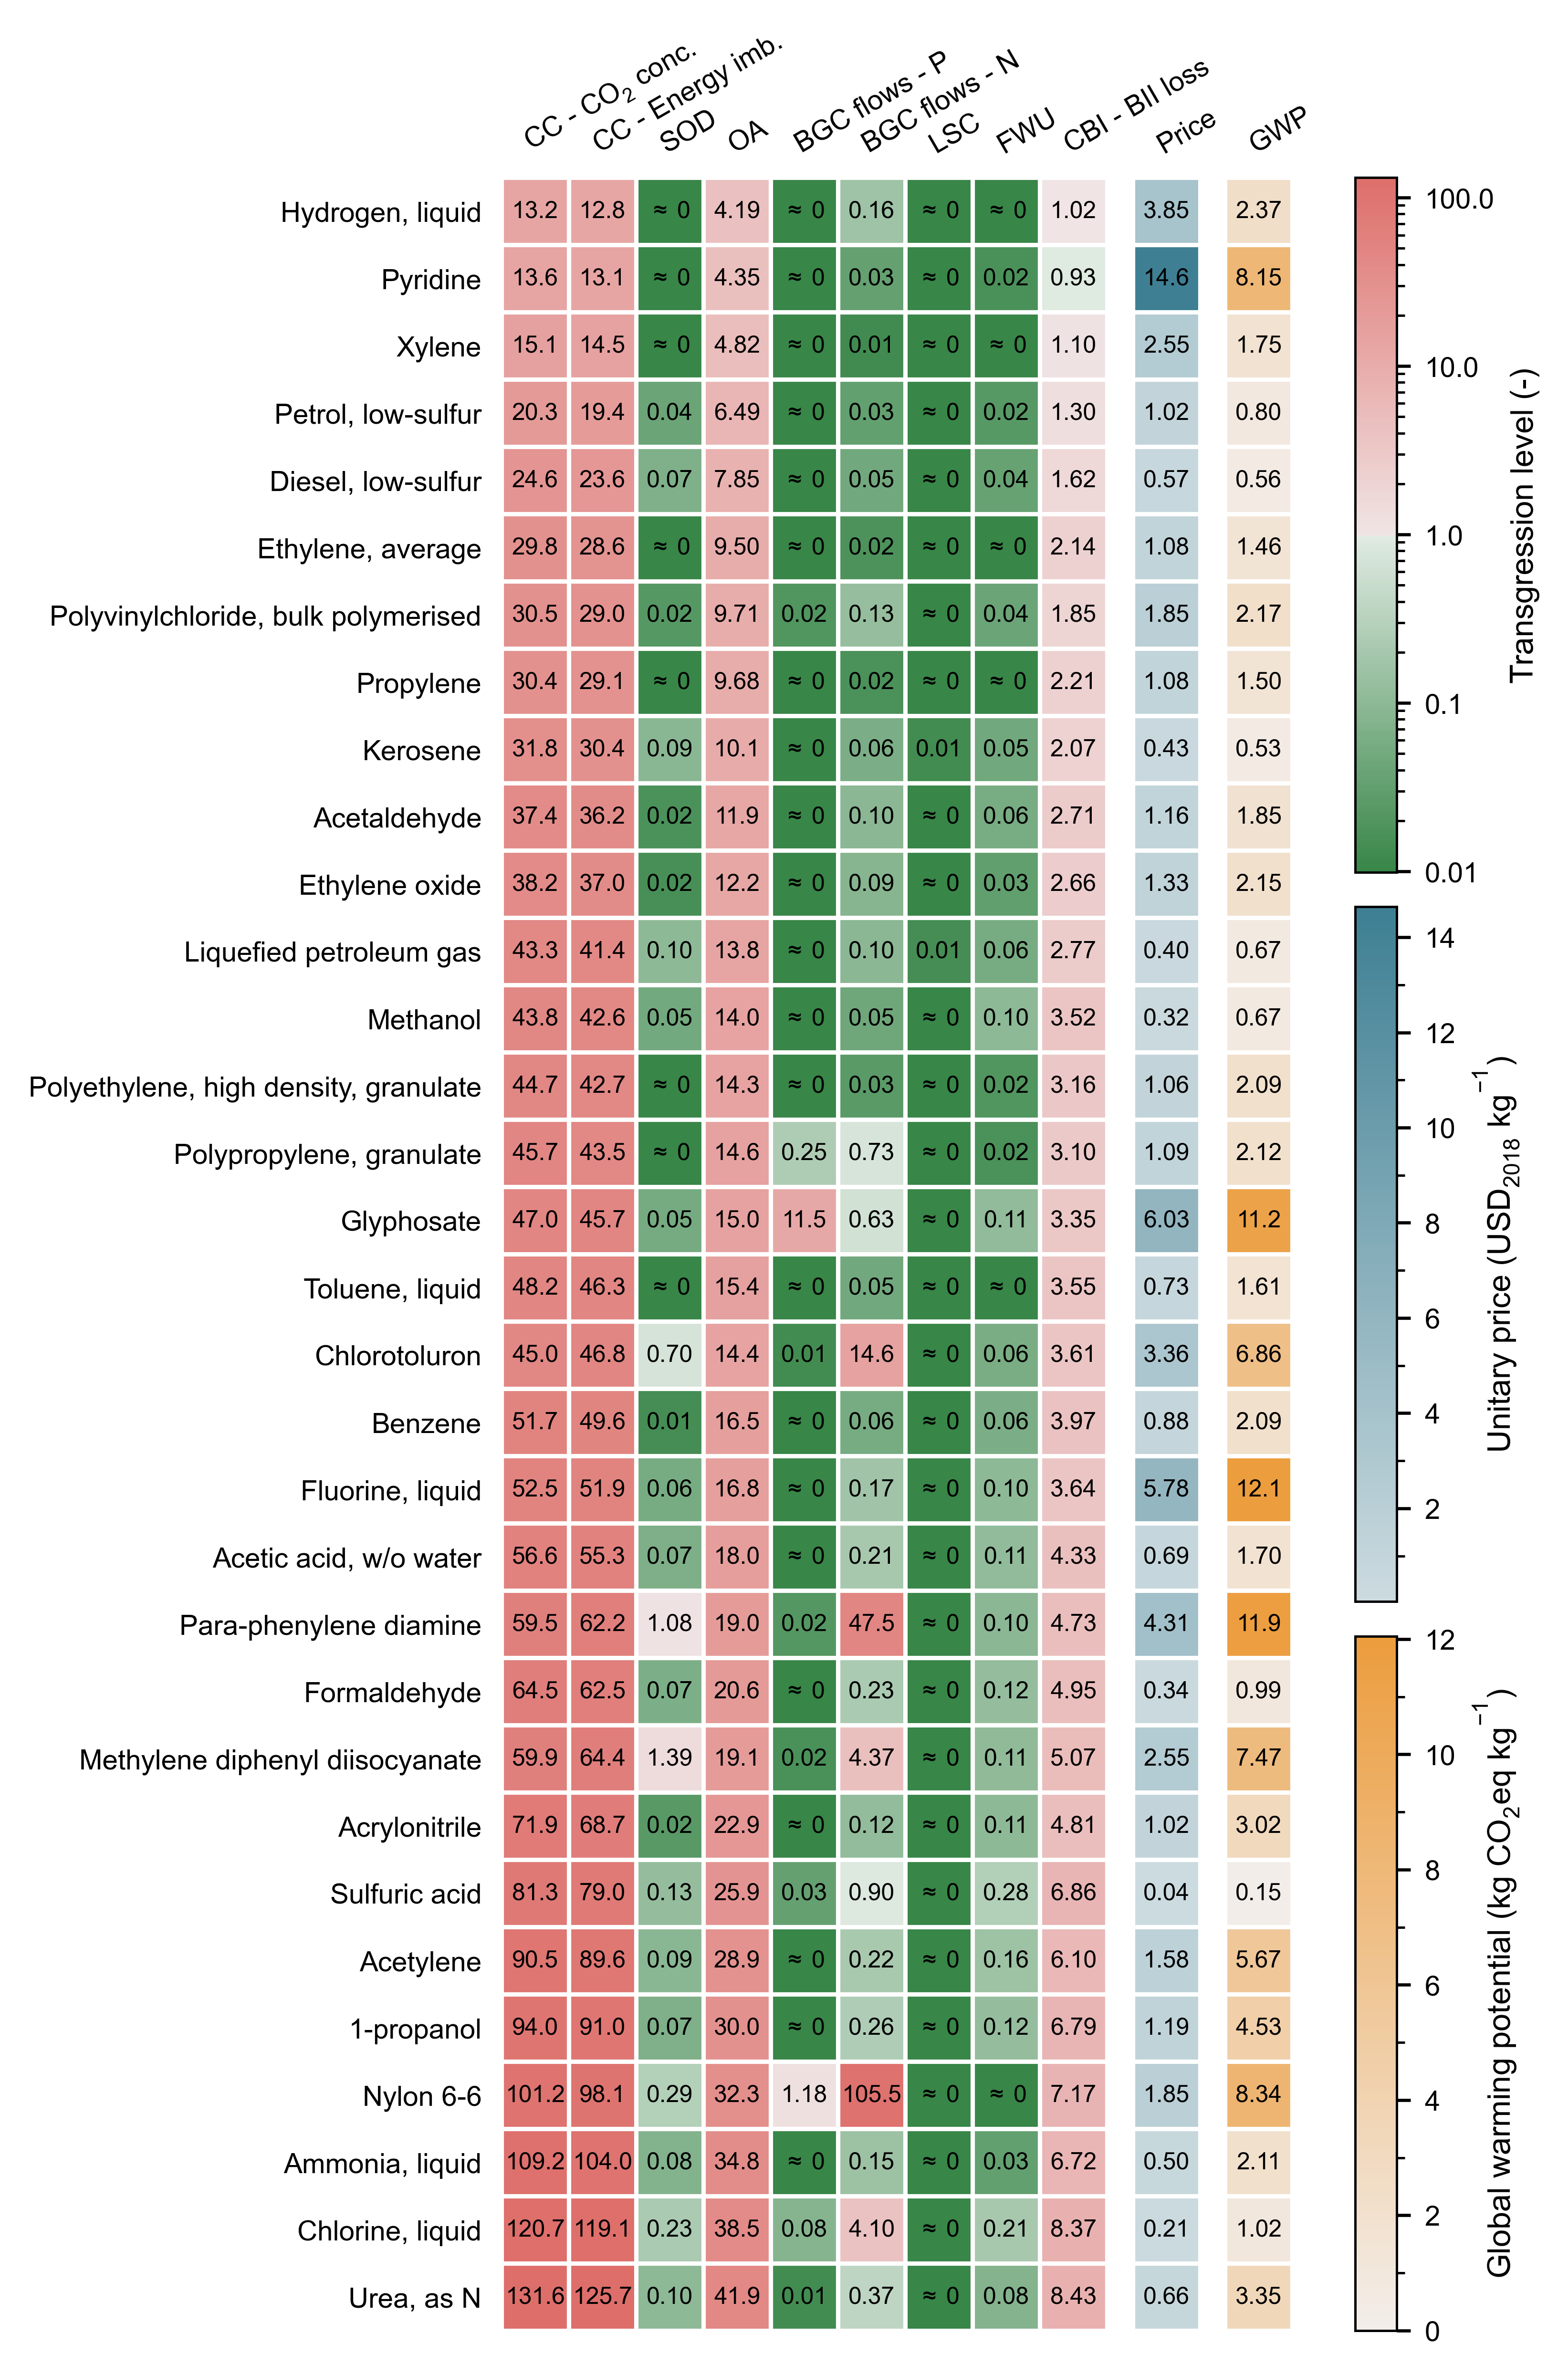

In [136]:
print("Used df: ", namedf)

# Plot

df_prices = df_plot.iloc[:,:1] # prices
df_GWP = df_plot.iloc[:, 3:4] # carbon footprint
df_TLonPBs = df_plot.iloc[:, 13:] # TL on PBs

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 43  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 16.5 - 4  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 15  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Figure specifications (fonts, sizes, figsize, etc.)
size_legend_font = 8
size_tick_font = 7
size_label_font = 8
mpl.rc("xtick", labelsize=size_tick_font)
mpl.rc("ytick", labelsize=size_tick_font)
mpl.rc("axes", labelsize=size_label_font, linewidth=0.6)
mpl.rc("font", family="Arial")
mpl.rc("mathtext", default="regular")

# Size of the figure
# fig_width = 150  # DEPENDS ON fig_height
fig_height = 220 - num_outliers_on_heatmap*6 # added the outliers manually

#### data for gridspec of the heatmap only, ADD MANUALLY !
numrows_hm = 1
numcols_hm = 3
ratio_of_widths_hm = [9, 1, 1]
w_space_hm = 0.1  # amount of space between subplots, fraction of the average axis width
# --------
numrows_fig = 1
numcols_fig = 2
ratio_of_widths_fig = [0.95, 0.05]
w_space_fig = 0.15

# ############## Specific calculations for this heatmap only:
# length of a cell (they are squares by default)
cell_length = (fig_height - from_top - from_bottom) / df_plot.index.size
cells_width = cell_length * np.asarray(ratio_of_widths_hm)
space_length = np.mean(cells_width) * w_space_hm
spacing = (numcols_hm - 1) * space_length
heatmap_width = sum(cells_width, spacing)
# ------------
fig_spacing = heatmap_width * 0.5 / ratio_of_widths_fig[0] * w_space_fig
cbar_width = heatmap_width * ratio_of_widths_fig[1] / ratio_of_widths_fig[0]

fig_width = np.ceil(from_left + from_right + heatmap_width + fig_spacing + cbar_width)
print(
    "Size of the figure:\nSpecified height is {} mm \nCalculated width is {} mm".format(
        fig_height, fig_width
    )
)
# ##########################################

size_in_mm = (fig_width, fig_height)  # input the desired size in mm (width, height)

fig = plt.figure(
    figsize=[x / 25.4 for x in size_in_mm],
    dpi=600,
    #  tight_layout = {'pad': 0}
)
# specs of the higher level grid
gs = fig.add_gridspec(
    nrows=numrows_fig,
    ncols=numcols_fig,
    width_ratios=ratio_of_widths_fig,
    wspace=w_space_fig,
    top=1 - from_top / size_in_mm[1],
    bottom=from_bottom / size_in_mm[1],
    left=from_left / size_in_mm[0],
    right=1 - from_right / size_in_mm[0],
)

# specs of the heatmap area grid
gs_heatmap = gs[0].subgridspec(
    nrows=numrows_hm,
    ncols=numcols_hm,
    width_ratios=ratio_of_widths_hm,
    wspace=w_space_hm,
)

# specs of the colorbar are grid
gs_cbar = gs[1].subgridspec(nrows=3, ncols=1, hspace=0.05)

ax1 = fig.add_subplot(gs_heatmap[0])
ax2 = fig.add_subplot(gs_heatmap[1], sharey=ax1,)
ax3 = fig.add_subplot(gs_heatmap[2], sharey=ax1,)
ax4 = fig.add_subplot(gs_cbar[0])
ax5 = fig.add_subplot(gs_cbar[1])
ax6 = fig.add_subplot(gs_cbar[2])


# --------------------------- LEFT and its COLORBAR ---------------------------
Z = df_TLonPBs.to_numpy()
Z[Z<=0.0099] = 0.0099


im1 = heatmap(
    df_TLonPBs.to_numpy(),
    df_TLonPBs.index.values,
    df_TLonPBs.columns.values,
    ax=ax1,
#     norm=TwoSlopeNorm(vcenter=1),
    norm=MidPointLogNorm(vmin=Z.min(), vmax=Z.max(), midpoint=1),
    cmap=cmap_center,
)

ax1.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax1.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax1.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im1, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(
    textwrap.wrap("Transgression level (-)", 60)
)
cbar1 = ax1.figure.colorbar(im1, cax=ax4, ax=None)
cbar1.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar1.ax.yaxis.set_label_position("right")
# cbar1.ax.invert_yaxis()
cbar1.ax.minorticks_on()
cbar1.ax.yaxis.set_major_locator(LogLocator(base=10))
cbar1.ax.yaxis.set_major_formatter(StrMethodFormatter("{x}")) # ScalarFormatter()) # StrMethodFormatter('{x:.0f}'))
cbar1.ax.yaxis.set_minor_formatter(NullFormatter())
# cbar1.ax.yaxis.set_minor_locator(MultipleLocator(5))


# --------------------------- CENTER and its COLORBAR ---------------------------
im2 = heatmap(
    df_prices.to_numpy(),
    df_prices.index.values,
    df_prices.columns.values,
    ax=ax2,
    cmap=cmap_right,
)

ax2.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax2.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax2.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im2, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(
    textwrap.wrap(r"Unitary price ($USD_{2018}$ $kg^{-1}$)", 40)
)
cbar2 = ax2.figure.colorbar(im2, cax=ax5, ax=None)
cbar2.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar2.ax.yaxis.set_label_position("right")
# cbar2.ax.invert_yaxis()
cbar2.ax.minorticks_on()
cbar2.ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.setp(ax2.get_yticklabels(), visible=False)  # remove yticklabels

# --------------------------- RIGHT and its COLORBAR ---------------------------
im3 = heatmap(
    df_GWP.to_numpy(),
    df_GWP.index.values,
    df_GWP.columns.values,
    ax=ax3,
    norm=TwoSlopeNorm(vcenter=0),
    cmap=cmap_left,
)

ax3.tick_params(axis="both", which="both", length=0.001, pad=5)
plt.setp(ax3.get_xticklabels(), rotation=30, ha="left", rotation_mode="anchor")

ax3.grid(which="minor", color="w", linestyle="-", linewidth=1.1)
annotate_heatmap(im=im3, color="k", fontsize=6)  # Annotate heatmap

# colorbar
cbarlabel = "\n".join(textwrap.wrap(r"Global warming potential (kg $CO_{2}$eq $kg^{-1}$)", 70))
cbar3 = ax3.figure.colorbar(im3, cax=ax6, ax=None)
cbar3.ax.set_ylabel(cbarlabel, rotation=90, va="bottom")
cbar3.ax.yaxis.set_label_position("right")
# cbar1.ax.invert_yaxis()
cbar3.ax.minorticks_on()
cbar3.ax.yaxis.set_minor_locator(MultipleLocator(1))
# cbar3.ax.yaxis.set_major_locator(MultipleLocator(5))

plt.setp(ax3.get_yticklabels(), visible=False)  # remove yticklabels

## EXPORT FIGURE
# figNamePNG = "Fig4_{}.png".format(namedf) # "Fig4_sortedCCEngImb.png"
# figNameSVG = "Fig4_{}.svg".format(namedf) #"Fig4_sortedCCEngImb.svg"

# plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
# plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg
plt.show()

#### additional steps

In [287]:
# df_plot.iloc[:, 14:15]

In [137]:
df2.loc[89]

NameError: name 'df2' is not defined

In [138]:
df_base_CPC33to35[df_base_CPC33to35.referenceProduct == 
#                   "Nylon 6-6" # no match
#                   "Adipic acid" # outlier?
                  "Ammonium nitrate, as N" # outlier?
                 ]

NameError: name 'df_base_CPC33to35' is not defined

In [139]:
maxval = df_plot.iloc[:, 14:15].max()[0]
minval = df_plot.iloc[:, 14:15].min()[0]
print("max: ", maxval)
print("min: ", minval)
df_plot[
    df_plot["TL in Climate change - Energy imbalance"].isin([maxval, minval])
]

max:  125.73596422932062
min:  12.794606401568299


KeyError: 'TL in Climate change - Energy imbalance'

In [366]:
# df_to_detect_outl.iloc[:, 40:41]

In [367]:
maxval = df_to_detect_outl.iloc[:, 40:41].max()[0]
minval = df_to_detect_outl.iloc[:, 40:41].min()[0]
df_to_detect_outl[
    df_to_detect_outl[
        "TL in ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"
    ].isin([maxval, minval])
]

Activity  category_regrouped  \
884      Trimesoyl chloride {GLO}| market for | APOS, S  Inorganic chemical   
1128  Sulfur hexafluoride, liquid, combined to GLO m...  Inorganic chemical   

                                       activity_comment      type  \
884   Production volume: 4 kgIncluded activities ...  Products   
1128                                               None  Products   

                 referenceProduct                  category  \
884            Trimesoyl chloride  Chemicals\Organic\Market   
1128  Sulfur hexafluoride, liquid    Chemicals\Gases\Market   

                     inline_comment  geo                   activity_ISICclass  \
884   Production Volume Amount: 4  GLO  2011:Manufacture of basic chemicals   
1128                           None  GLO  2011:Manufacture of basic chemicals   

     activity_ecoSpold01class  technologyLevel  referenceProductAmount  \
884        chemicals/organics              0.0                       1   
1128                      NaN              NaN                       1   

     referenceProductUnit  referenceProduct_prodVolume  \
884                    kg                          4.0   
1128                   kg                          4.0   

     referenceProduct_prodVolumeComment  referenceProduct_price  \
884                                 NaN                  990.00   
1128                               None                    3.39   

     referenceProduct_priceUnit  \
884                     EUR2005   
1128                    EUR2005   

                          referenceProduct_priceComment  \
884   Estimated based on purchaser prices available ...   
1128                                               None   

     referenceProduct_casNumber              referenceProduct_CPCclass  \
884                   4422-95-1  342: Basic inorganic chemicals n.e.c.   
1128                002551-62-4  342: Basic inorganic chemicals n.e.c.   

                                activity_generalComment  \
884                                                 NaN   
1128  Combined activity, mass allocated from RER, Ro...   

                                         sourceFilename pubchem_match  \
884   23442_5a2c7eef-c5cb-4f96-b3ca-95abd11a17b2_4c4...        by CAS   
1128                                               None       by NAME   

      num_matches         MF      MW                               iupac  \
884             1  C9H3Cl3O3  265.50  benzene-1,3,5-tricarbonyl chloride   
1128            1        F6S  146.06          hexafluoro-lambda6-sulfane   

      complexity                                           synonyms  \
884        243.0  ['Trimesoyl chloride', '4422-95-1', '1,3,5-Ben...   
1128        62.7  ['SULFUR HEXAFLUORIDE', 'Sulphur hexafluoride'...   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
884                                            8.283052            
1128                                         127.060714            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
884                                        1.729510e-10                            
1128                                       2.349601e-10                            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
884                                        2.447114e-12                            
1128                                       3.387234e-10                            

      ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
884                                        6.543358e-13                      
1128                                       5.101999e-14                      

      ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
884                                        5.284927e-13                      
1128                                       7.179779e-13                      

      ('PBs-LCIA (baseline) V0.72', 'B

### fig ESI
<div class="alert alert-block alert-info">
  Bivariate analysis: Price of chemicals vs categories of PBs method <br>
    - scatter plots  <br>
</div>

#### Similar to Fig 3, but showing GWP vs PBs scores

r_spearman is 0.99
r_pearson is 1.0
$R^{2}$ = 1.00
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.99
r_pearson is 1.0
$R^{2}$ = 1.00
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.79
r_pearson is 0.99
$R^{2}$ = 0.97
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.99
r_pearson is 1.0
$R^{2}$ = 1.00
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.57
r_pearson is 0.1
$R^{2}$ = $1.09\times 10^{-2}$
min size: 0.2016, max size: 46.736000000000004
min size: 2.604, max size: 95.92000000000002
min size: 1.2011, max size: 54.11000000000001
r_spearman is 0.65
r_pearson is 0.76
$

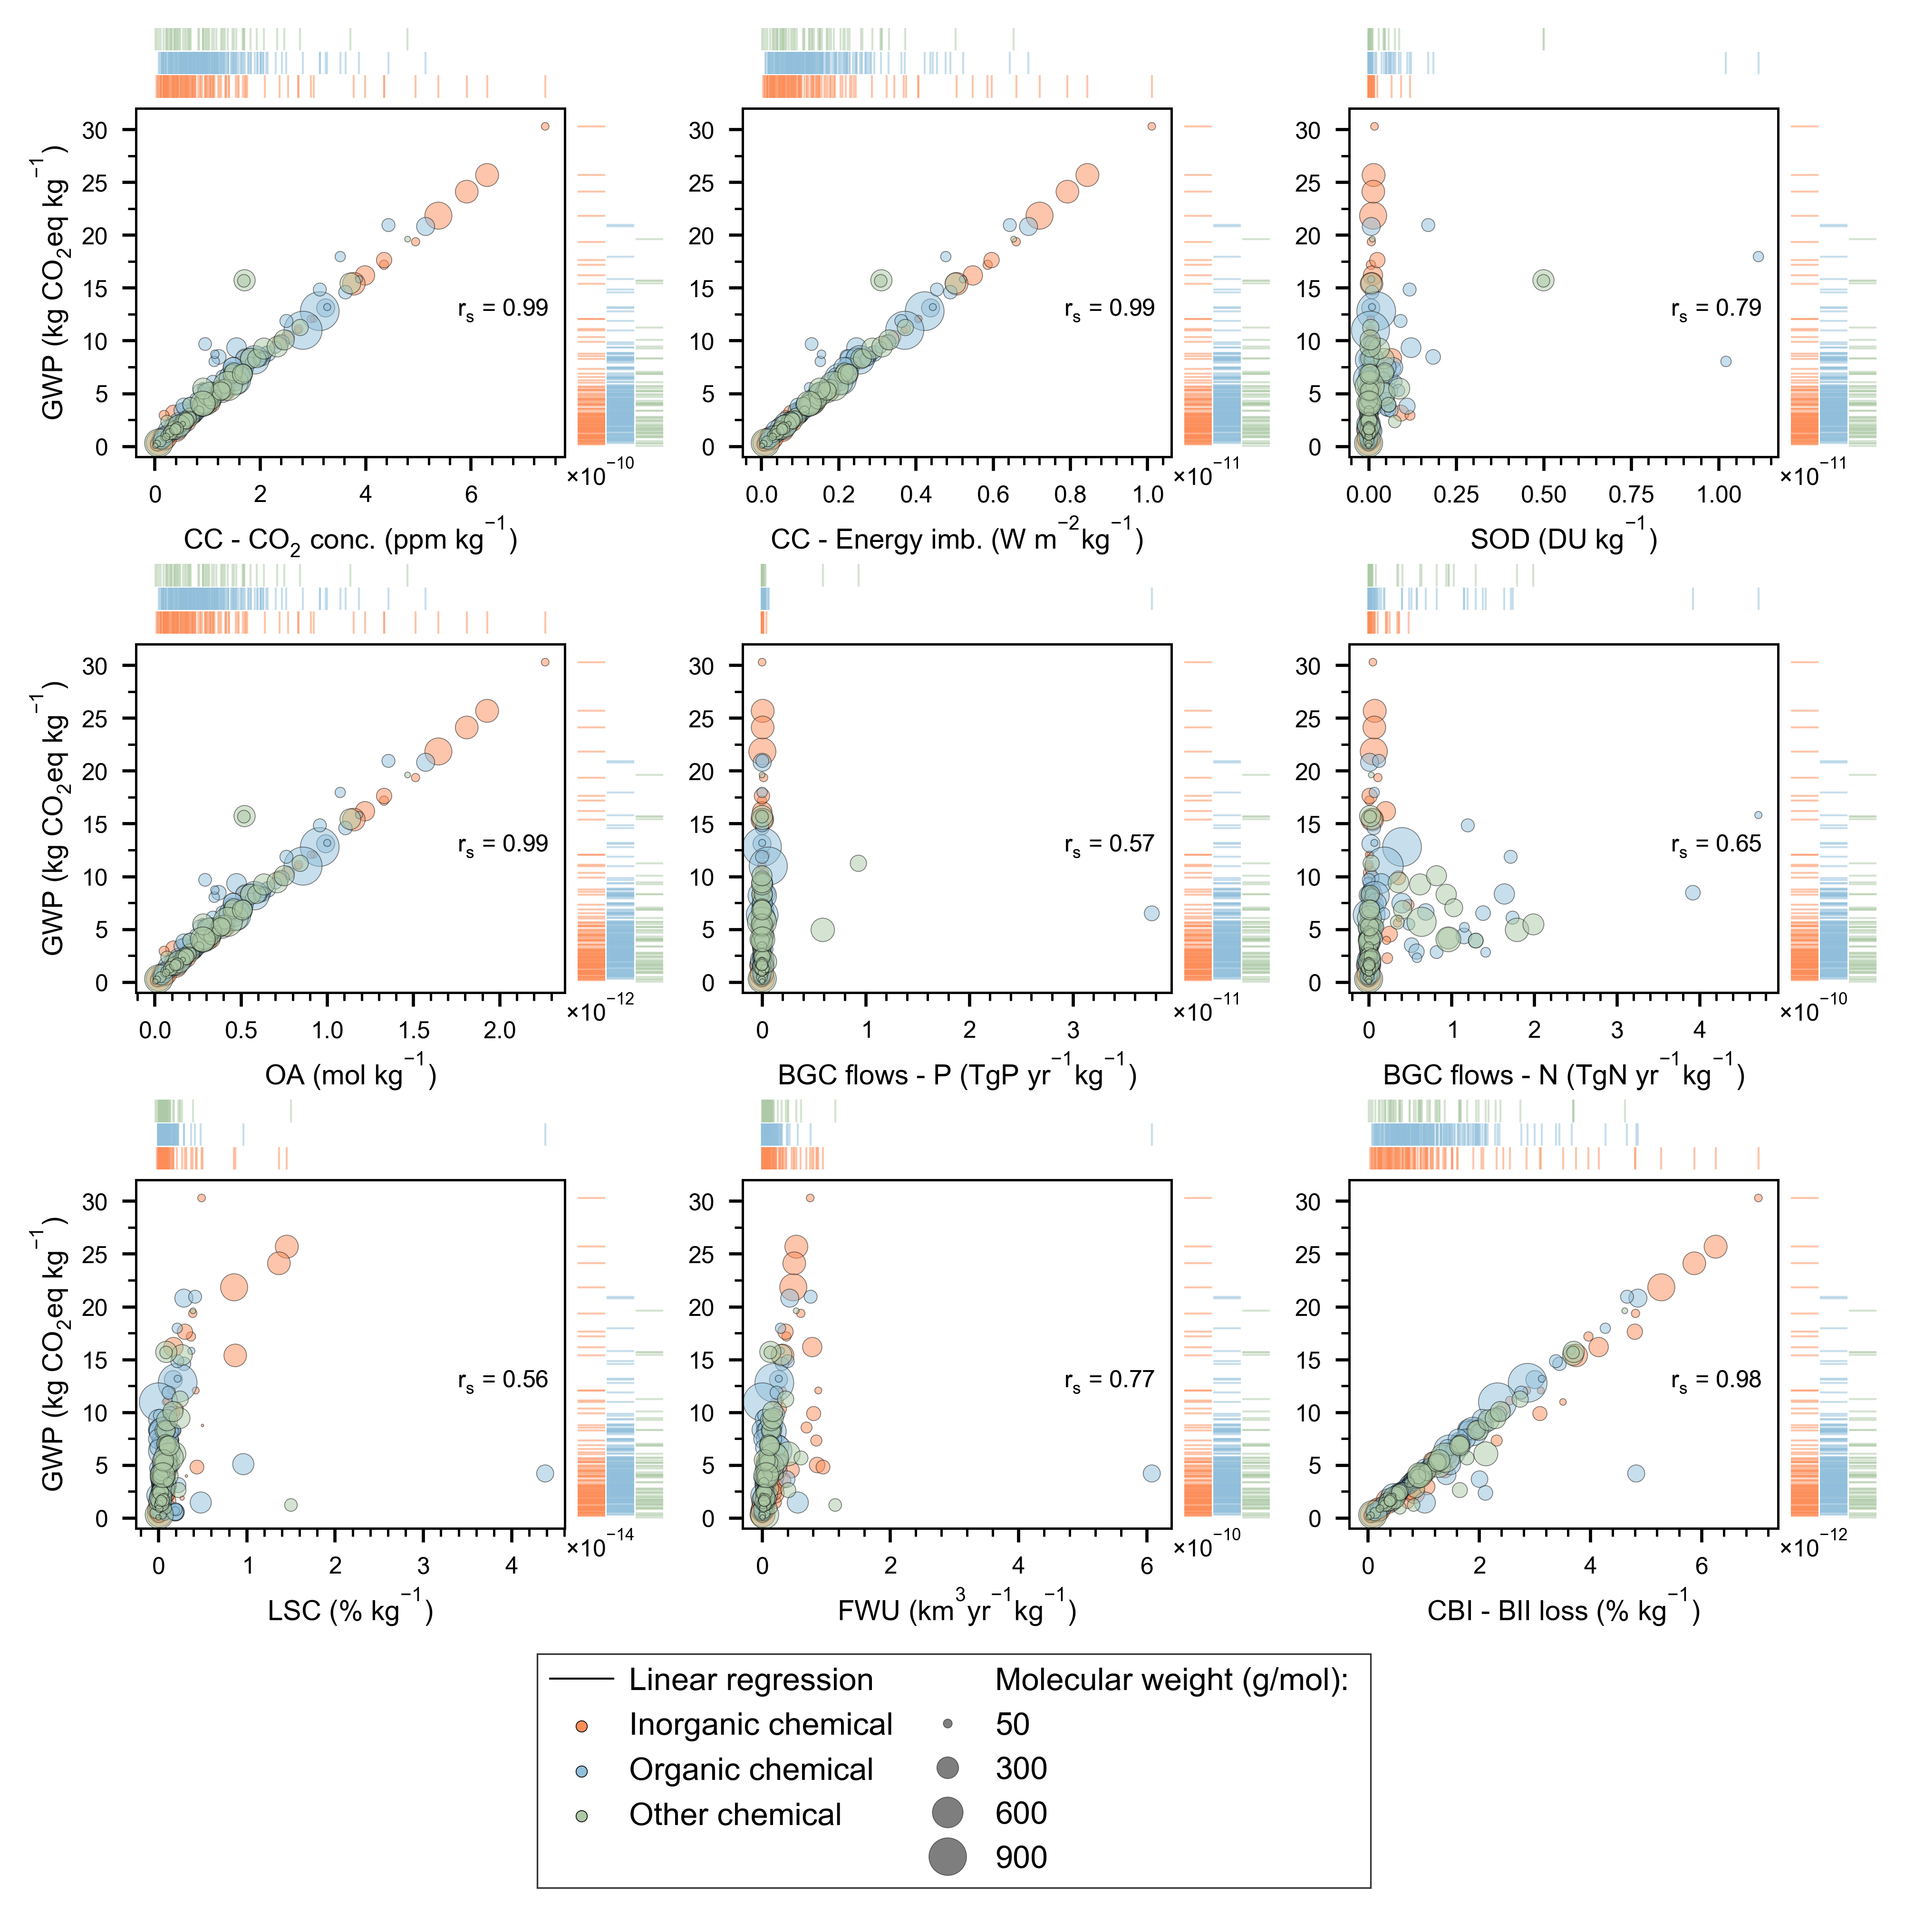

In [82]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods[1:]

# ================
# removing rows where GWP > 32
# this df is used only for plotting, not affecting r_spearman, nor r_pearson, nor R^2
df_toplot_clean = df_toplot[df_toplot[lst_methods[0]] <= 32]
# ================

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################


size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 171
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 14  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 2  # in mm
from_top = 2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.84, 0.16],
    #     wspace=0.15,
    hspace=0.1,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.15,
    hspace=0.25,
)

for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
#     y = np.log(y_raw[mask])  # !!! CHANGEd DUE TO set_yscale("log")

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)
    
    # Spearman's rank correlation coefficient
    # assesses monotonic relationships between variables
    r_spearman = x.corr(y, method='spearman').round(2)
    r_spearman_text = "$r_{s}$ = " + str(r_spearman)

    # Pearson correlation coefficient
    # assesses linear relationships between variables
    r_pearson = x.corr(y, method='pearson').round(2)
    
    print("r_spearman is {}\nr_pearson is {}".format(r_spearman, r_pearson))
    print(Rsquare)

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
#         width_ratios=[1.5, 1],
        width_ratios=[1.5, 0.3],
        wspace=0.05,
#         height_ratios=[1, 1.5],
        height_ratios=[0.3, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
#         nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
        nrows=3, ncols=1, height_ratios=[0.5, 0.5, 0.5], hspace=0.05,        
    )
    ax_4 = gs_PB[3].subgridspec(
#         nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
        nrows=1, ncols=3, width_ratios=[0.5, 0.5, 0.5], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
#     ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
#     ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
#     stat_text = calculate_stats(x)
#     #     stat_of_GWP = calculate_stats(y)
#     #     pprint.pprint(stat_of_GWP)
#     ax_2.text(
#         0.15,
#         0.3,
#         stat_text,
#         fontsize=5.5,
#         linespacing=1,
#         va="bottom",
#         ha="left",
#         multialignment="left",
#         bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
#         # frameon=True, # prop=dict(size=6),  #loc="center",
#     )
#     #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
#     ax_2.annotate(
#         "",
#         xy=(0.14, 0.7),
#         xycoords="axes fraction",
#         xytext=(-0.1, 0.7),
#         arrowprops=dict(
#             arrowstyle="<|-, head_length=0.3, head_width=0.15",
#             color="k",
#             linewidth=0.3,
#         ),
#     )
    ax_2.axis("off")

    grouped = dict(list(df_toplot_clean.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
        print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)
        # ---------- regression line ---------------
#         ax_3.plot(
#             X, Y_pred, color="black", lw=0.5,
#         )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        ##### replace Rsquare with r_spearman
#         if namedf  == "df_base_full_wCAS_woOutliersRMDk9a5":
#             if gsx == 7:
#                 xposR2 = 0.7
#             else:
#                 xposR2 = 0.55
#         else:
#             xposR2 = 0.6  # 0.02
        xposR2 = 0.75
        yposR2 = 0.42

        ax_3.text(
            xposR2,
            yposR2,
#             Rsquare,
            r_spearman_text,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
#         ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i-1], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~######################## ax_3 axes ######  
    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)
#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs_plot[cat][0] + " (" + dict_pbs_plot[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap(dict_pbs_plot[cat][0] + " ("+ dict_pbs_plot[cat][1] +")", 50)
    )

#         ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)
    ax_3.set_xlabel(xlabel=xlabelname, labelpad=2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        # ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)
#         ax_3.set_yscale('log')
    
#     Y axis limit
    ax_3.set_ylim(top=32)
    ax_3.set_ylim(bottom=-1)
    ax_3.yaxis.set_major_locator(MultipleLocator(5))
    ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.01: 5, 0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax_3.get_xticks())- min(ax_3.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax_3.get_xticks())< 1e-2: # > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -2  # -1
        max_exp = 3  # 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax_3.xaxis.set_major_formatter(formatter)
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax_3.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax_3.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax_3.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                #             xy=(0.76, 0.02),
                xy=(1.001, -0.08),
                xycoords="axes fraction",
                fontsize=6,
            )
    else:
        ax_3.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

#     # ---------- histogram top ---------------
#     ax_1_hist.hist(x, bins=50, color="grey")
#     #     ax_1_hist.set_xticks([])  # next 2 lines do this
#     ax_1_hist.tick_params(labelbottom=False)
#     #     ax_1_hist.tick_params(axis='x', which='both', length=0)
#     ax_1_hist.spines["top"].set_visible(False)
#     #     ax_1_hist.spines['left'].set_visible(False)
#     ax_1_hist.spines["right"].set_visible(False)
#     #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
#     #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
#     ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # ---------- histogram right ---------------
#     ax_4_hist.hist(y, bins=50, orientation="horizontal", color="grey")
#     #     ax_4_hist.set_yticks([]) # next 2 lines do this
#     ax_4_hist.tick_params(labelleft=False)
#     #     ax_4_hist.tick_params(axis='y', which='both', length=0)
#     ax_4_hist.xaxis.tick_top()
#     #     ax_4_hist.spines['top'].set_visible(False)
#     ax_4_hist.spines["bottom"].set_visible(False)
#     ax_4_hist.spines["right"].set_visible(False)
#     #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
#     #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
#     ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
ax_3.scatter(
    [], [], color="w", lw=0.0, label=" "
)  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
ax_3.scatter(
    [], [], color="w", lw=0.0, label=size_label
)  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 2

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other + handles_size + handles_hp,
        labels_other + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
figNamePNG = "Fig_ESI-GWP-vs-PBs-{}.png".format(namedf)
figNameSVG = "Fig_ESI-GWP-vs-PBs-{}.svg".format(namedf)

plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

#### Similar to Fig 3, but showing GWP vs PBs scores and histograms on sides...

r_spearman is 0.99
r_pearson is 1.0
$R^{2}$ = 1.00
r_spearman is 0.99
r_pearson is 1.0
$R^{2}$ = 1.00
r_spearman is 0.79
r_pearson is 0.99
$R^{2}$ = 0.97
r_spearman is 0.99
r_pearson is 1.0
$R^{2}$ = 1.00
r_spearman is 0.57
r_pearson is 0.1
$R^{2}$ = $1.09\times 10^{-2}$
r_spearman is 0.65
r_pearson is 0.76
$R^{2}$ = 0.58
r_spearman is 0.56
r_pearson is 1.0
$R^{2}$ = 0.99
r_spearman is 0.77
r_pearson is 0.99
$R^{2}$ = 0.99
r_spearman is 0.98
r_pearson is 1.0
$R^{2}$ = 1.00


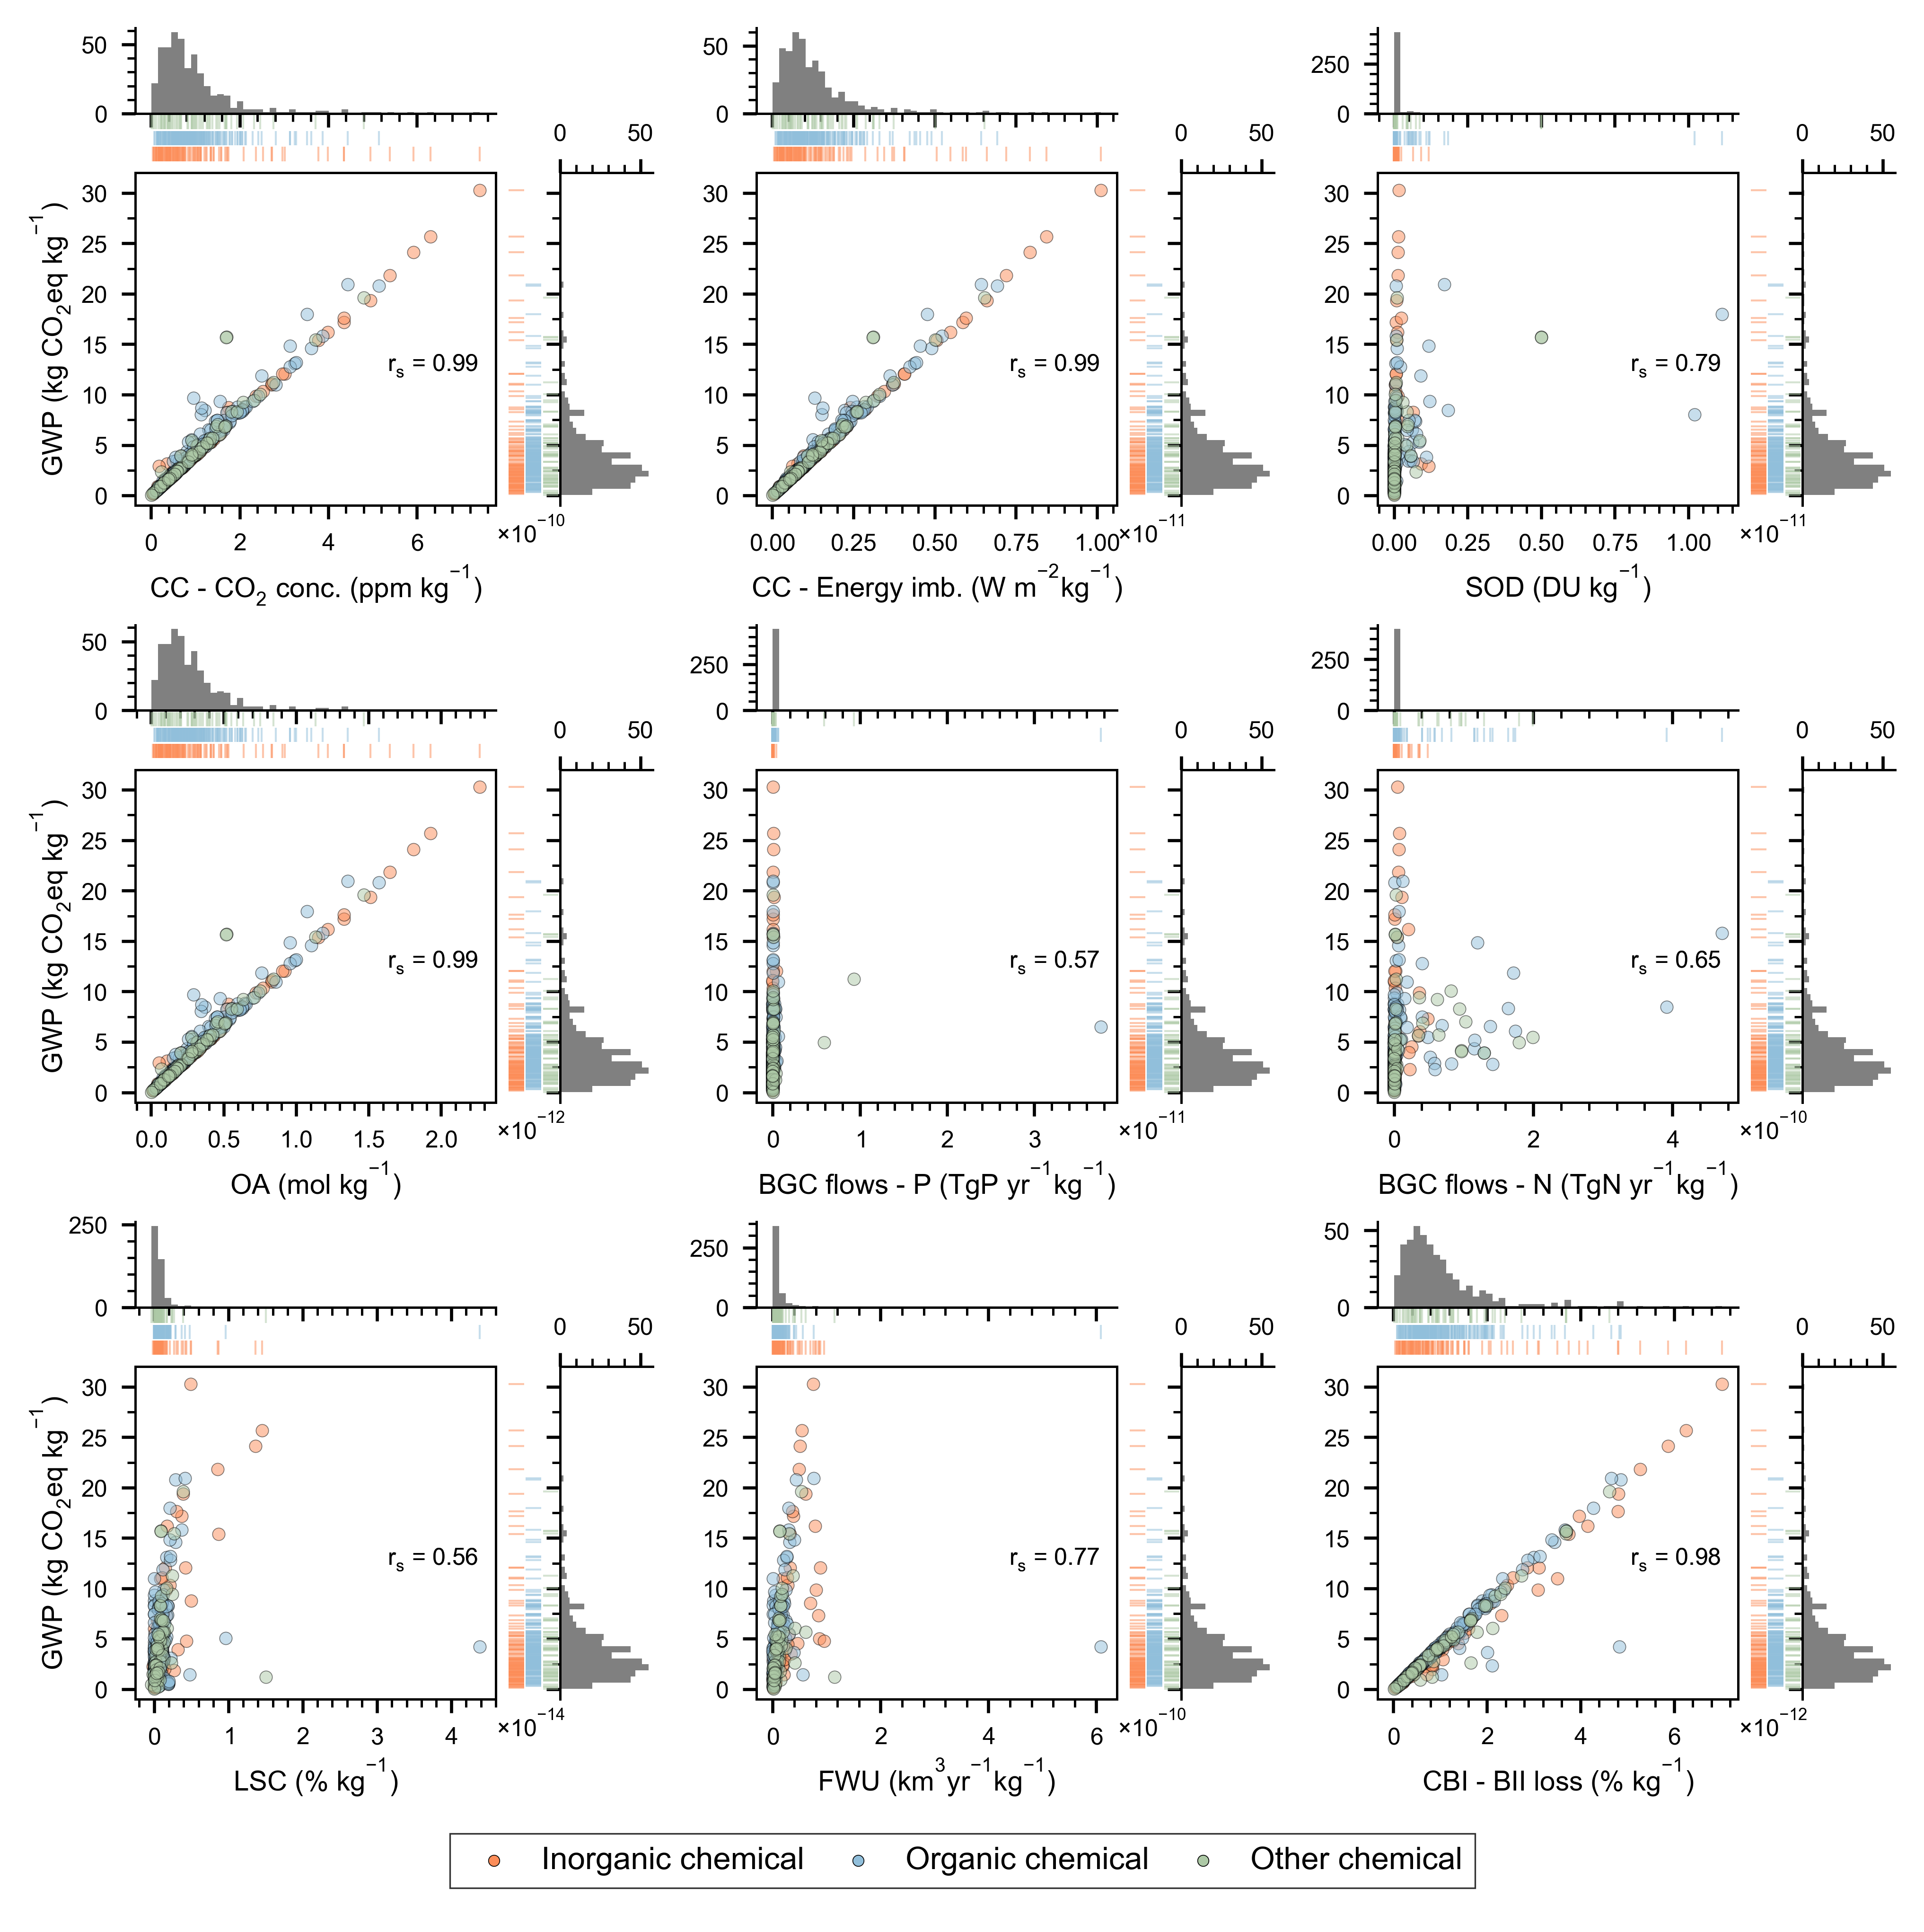

In [83]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods[1:]

# ================
# removing rows where GWP > 32
# this df is used only for plotting, not affecting r_spearman, nor r_pearson, nor R^2
df_toplot_clean = df_toplot[df_toplot[lst_methods[0]] <= 32]
# ================

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = {"TL in " + str(key): val for key, val in dict_pbs.items()}
else:
    dict_pbs_plot = dict_pbs

######################

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 171
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 11.5  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 1  # in mm
from_top = 2.2  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:-1) - separate [subplots, legend]
gs_null = fig.add_gridspec(
    nrows=2,
    ncols=1,
    #     width_ratios=[1, 1, 1],
    height_ratios=[0.9, 0.1],
#     wspace=0.1,
    hspace=0.02,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)


# Grid specification (level:0)
gs = gs_null[0].subgridspec(
    nrows=3,
    ncols=3,
    width_ratios=[1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.2,
    hspace=0.25,
)

for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot[lst_methods[0]]
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
#     y = np.log(y_raw[mask])  # !!! CHANGEd DUE TO set_yscale("log")

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)
    
    # Spearman's rank correlation coefficient
    # assesses monotonic relationships between variables
    r_spearman = x.corr(y, method='spearman').round(2)
    r_spearman_text = "$r_{s}$ = " + str(r_spearman)

    # Pearson correlation coefficient
    # assesses linear relationships between variables
    r_pearson = x.corr(y, method='pearson').round(2)
    
    print("r_spearman is {}\nr_pearson is {}".format(r_spearman, r_pearson))
    print(Rsquare)

    # Grid specification (level:1)
    gs_PB = gs[gsx].subgridspec(
        nrows=2,
        ncols=2,
        width_ratios=[1.5, 0.6],
#         width_ratios=[1.5, 0.3],
        wspace=0.05,
        height_ratios=[0.6, 1.5],
#         height_ratios=[0.3, 1.5],
        hspace=0.05,
    )

    # Grid specification (level:2)
    ax_1 = gs_PB[0].subgridspec(
        nrows=4, ncols=1, height_ratios=[3, 0.5, 0.5, 0.5], hspace=0.05,
#         nrows=3, ncols=1, height_ratios=[0.5, 0.5, 0.5], hspace=0.05,        
    )
    ax_4 = gs_PB[3].subgridspec(
        nrows=1, ncols=4, width_ratios=[0.5, 0.5, 0.5, 3], wspace=0.05,
#         nrows=1, ncols=3, width_ratios=[0.5, 0.5, 0.5], wspace=0.05,
    )

    # Subplots ....
    ax_2 = fig.add_subplot(gs_PB[1])  # annotation
    ax_3 = fig.add_subplot(gs_PB[2])  # scatter plot
    # ======
    ax_1_hist = fig.add_subplot(ax_1[0], sharex=ax_3)  # histogram top
    ax_4_hist = fig.add_subplot(ax_4[3], sharey=ax_3)  # histogram left

    # ---------- annotation ----------
#     stat_text = calculate_stats(x)
#     #     stat_of_GWP = calculate_stats(y)
#     #     pprint.pprint(stat_of_GWP)
#     ax_2.text(
#         0.15,
#         0.3,
#         stat_text,
#         fontsize=5.5,
#         linespacing=1,
#         va="bottom",
#         ha="left",
#         multialignment="left",
#         bbox=dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.3),
#         # frameon=True, # prop=dict(size=6),  #loc="center",
#     )
#     #     ax_2.arrow(0, 0.5, -0.15, 0, head_width=0.005, head_length=0.01, fc='k', ec='k')
#     ax_2.annotate(
#         "",
#         xy=(0.14, 0.7),
#         xycoords="axes fraction",
#         xytext=(-0.1, 0.7),
#         arrowprops=dict(
#             arrowstyle="<|-, head_length=0.3, head_width=0.15",
#             color="k",
#             linewidth=0.3,
#         ),
#     )
    ax_2.axis("off")

    grouped = dict(list(df_toplot_clean.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group[lst_methods[0]]

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
#         print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
        scplot = ax_3.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=10, #s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)
        # ---------- regression line ---------------
#         ax_3.plot(
#             X, Y_pred, color="black", lw=0.5,
#         )  # label="Linear regression")

        # position of Rsquared label (relative to fraction of the axes)
        ##### replace Rsquare with r_spearman
#         if namedf  == "df_base_full_wCAS_woOutliersRMDk9a5":
#             if gsx == 7:
#                 xposR2 = 0.7
#             else:
#                 xposR2 = 0.55
#         else:
#             xposR2 = 0.6  # 0.02
        xposR2 = 0.70
        yposR2 = 0.42

        ax_3.text(
            xposR2,
            yposR2,
#             Rsquare,
            r_spearman_text,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax_3.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )

        #         ############ !!!!!!!!!!!!!!!!!! plot the highlighted products  # NO highlighted_products
        #         xlim_ax = ax_3.get_xlim()
        #         xaxis_size = xlim_ax[1] - xlim_ax[0]
        #         xoffset = 0.05 * xaxis_size
        #         ylim_ax = ax_3.get_ylim()
        #         yaxis_size = ylim_ax[1] - ylim_ax[0]
        #         yoffset = -0.005 * yaxis_size

        #         for n, prod in enumerate(highlighted_product):
        #             i_prod = [i for i in group.index if prod == group.referenceProduct[i]]
        #             try:
        #                 if i_prod:
        #                     ax_3.scatter(x_group[i_prod], y_group[i_prod],
        #                                  marker="X", c="r", s=8, linewidths=0.2, ec="k", zorder=2.5)

        #                     xy_coor = (x_group[i_prod] + xoffset, y_group[i_prod] + yoffset)
        #                     ax_3.annotate(n + 1, xy_coor, fontsize=6, color="k")
        #             except:
        #                 pass
        #         ############ !!!!!!!!!!!!!!!!!!

        # ---------- top rug plots ---------------
        ax_1_rug = fig.add_subplot(ax_1[tot_keys - i], sharex=ax_3)
#         ax_1_rug = fig.add_subplot(ax_1[tot_keys - i-1], sharex=ax_3)
        sns.rugplot(
            x=x_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_1_rug,
        )
        ax_1_rug.spines["top"].set_visible(False)
        ax_1_rug.spines["bottom"].set_visible(False)
        ax_1_rug.spines["left"].set_visible(False)
        ax_1_rug.spines["right"].set_visible(False)
        ax_1_rug.axis("off")
        #         ax_1_rug.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])

        # ---------- right rug plots ---------------
        ax_4_rug = fig.add_subplot(ax_4[i], sharey=ax_3)
        sns.rugplot(
            y=y_group,
            c=plot_colors[key],
            #             clip_on=True,
            height=1,
            lw=0.5,
            alpha=0.5,
            expand_margins=False,
            ax=ax_4_rug,
        )
        ax_4_rug.spines["top"].set_visible(False)
        ax_4_rug.spines["bottom"].set_visible(False)
        ax_4_rug.spines["left"].set_visible(False)
        ax_4_rug.spines["right"].set_visible(False)
        ax_4_rug.axis("off")
    #         ax_4_rug.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])

    # ~######################## ax_3 axes ######  
    #         ax_3.set_ylabel(ylabel="Global Warming Potential (kg $CO_{2-eq}$)")
    ax_3.set_ylabel(ylabel="GWP (kg $CO_{2}eq\ kg^{-1}$)", labelpad=2.3)
#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs_plot[cat][0] + " (" + dict_pbs_plot[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap(dict_pbs_plot[cat][0] + " ("+ dict_pbs_plot[cat][1] +")", 50)
    )

#         ax_3.set_xlabel(xlabel=xlabelname, labelpad=0.2)
    ax_3.set_xlabel(xlabel=xlabelname, labelpad=2)

    xlim_ax3 = ax_3.get_xlim()
    ylim_ax3 = ax_3.get_ylim()

    if gsx in [1, 2, 4, 5, 7, 8]:
        # ax_3.set_yticks([])
        ax_3.set_ylabel(None)
    #         ax_3.get_yaxis().set_visible(False)
    #     ax_3.grid(True)
#         ax_3.set_yscale('log')
    
#     Y axis limit
    ax_3.set_ylim(top=32)
    ax_3.set_ylim(bottom=-1)
    ax_3.yaxis.set_major_locator(MultipleLocator(5))
    ax_3.yaxis.set_minor_locator(AutoMinorLocator(2))
    
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.01: 5, 0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax_3.get_xticks())- min(ax_3.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax_3.get_xticks())< 1e-2: # > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -2  # -1
        max_exp = 3  # 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax_3.xaxis.set_major_formatter(formatter)
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(5))
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax_3.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax_3.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax_3.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                #             xy=(0.76, 0.02),
                xy=(1.001, -0.11),
                xycoords="axes fraction",
                fontsize=6,
            )
    else:
        ax_3.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax_3.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

    # ---------- histogram top ---------------    
    x_raw_clean = df_toplot_clean[cat]
    y_raw_clean = df_toplot_clean[lst_methods[0]]
    # Remove Nan values
    mask_clean = ~np.isnan(x_raw_clean) & ~np.isnan(y_raw_clean)
    x_clean = x_raw_clean[mask_clean]
    y_clean = y_raw_clean[mask_clean]
    
    ax_1_hist.hist(x_clean, bins=50, color="grey")
    #     ax_1_hist.set_xticks([])  # next 2 lines do this
    ax_1_hist.tick_params(labelbottom=False)
    #     ax_1_hist.tick_params(axis='x', which='both', length=0)
    ax_1_hist.spines["top"].set_visible(False)
    #     ax_1_hist.spines['left'].set_visible(False)
    ax_1_hist.spines["right"].set_visible(False)
    #     ax_1_hist.set_xlim(xmin=xlim_ax3[0], xmax=xlim_ax3[1])
    #     ax_1_hist.yaxis.set_major_locator(MultipleLocator(2))
    ax_1_hist.yaxis.set_minor_locator(AutoMinorLocator(5))

    # ---------- histogram right ---------------
    ax_4_hist.hist(y_clean, bins=50, orientation="horizontal", color="grey")
    #     ax_4_hist.set_yticks([]) # next 2 lines do this
    ax_4_hist.tick_params(labelleft=False)
    #     ax_4_hist.tick_params(axis='y', which='both', length=0)
    ax_4_hist.xaxis.tick_top()
    #     ax_4_hist.spines['top'].set_visible(False)
    ax_4_hist.spines["bottom"].set_visible(False)
    ax_4_hist.spines["right"].set_visible(False)
    #     ax_4_hist.set_ylim(ymin=ylim_ax3[0], ymax=ylim_ax3[1])
    #     ax_4_hist.xaxis.set_major_locator(MultipleLocator(2))
    ax_4_hist.xaxis.set_minor_locator(AutoMinorLocator(5))


# Legend
# gs_legend = fig.add_subplot(gs[3, :])
gs_legend = fig.add_subplot(gs_null[1])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
range_size_dict = dict()
for p in scplot_list:
    range_size = p.get_sizes().max() - p.get_sizes().min()
    range_size_dict[p] = range_size
max_range_size = max(range_size_dict.values())
scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
    0
]  # getting the PathCollection with the largest range size
# ####
sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax_3.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
# ax_3.scatter(
#     [], [], color="w", lw=0.0, label=" "
# )  # dummy name placeholder to accomodate 2 columns
# ax_3.scatter([], [], marker="X", c="r", s=8, linewidths=0.2, ec="k", label="Highlighted chemical") # NO highlighted_products
# ax_3.plot([], [], color="black", lw=0.5, label="Linear regression")
# ax_3.scatter(
#     [], [], color="w", lw=0.0, label=size_label
# )  # dummy name placeholder 1, size_label defined above by "size_to_plot"
handles_other, labels_other = ax_3.get_legend_handles_labels()

# # highlighted_products # NO highlighted_products
# handles_hp, labels_hp = zip(*enumerate(highlighted_product))
# handles_hp = list(string.digits)[1:len(highlighted_product)+1] # [""] + list(string.digits)[1:len(highlighted_product)+1]
# labels_hp = list(labels_hp) # ["Chemicals: "] + list(labels_hp)

# Number of colums in the legend
ncolumns_legend = 3

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other,# + handles_size + handles_hp,
        labels_other,# + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
elif ncolumns_legend == 5:
    # alternate items of the 2 sublists in order to plot the legend in 2 ROWS!
    handles = [
        item
        for sublist in itertools.zip_longest(handles_other, handles_size)
        for item in sublist
    ]
    handles = [x for x in handles if x is not None]
    handles = [
        handles[0],
        handles[9],
        handles[2],
        handles[1],
        handles[4],
        handles[3],
        handles[6],
        handles[5],
        handles[8],
        handles[7],
    ]

    labels = [
        item
        for sublist in itertools.zip_longest(labels_other, labels_size)
        for item in sublist
    ]
    labels = [x for x in labels if x is not None]
    labels = [
        labels[0],
        labels[9],
        labels[2],
        labels[1],
        labels[4],
        labels[3],
        labels[6],
        labels[5],
        labels[8],
        labels[7],
    ]
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="lower center",
    bbox_to_anchor=(0.47, 0.0),
    ncol=ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
figNamePNG = "Fig_ESI-GWP-vs-PBs-w-hist-{}.png".format(namedf)
figNameSVG = "Fig_ESI-GWP-vs-PBs-w-hist-{}.svg".format(namedf)

plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

#### Similar to Fig 3, but showing Prices vs GWP and PBs scores

In [86]:
pd.options.display.max_columns = None
# df_base_full_wCAS_woOutliersRMDk9a5
# referenceProduct_price

In [103]:
dict_labels_PBs = dict_pbs.copy()
dict_labels_PBs[lst_methods[0]] = ['GWP', 'kg $CO_{2}eq\ kg^{-1}$']
# dict_labels_PBs

In [93]:
dict_labels_TLs = dict_pbs_plot.copy()
dict_labels_TLs[lst_methods[0]] = ['GWP', 'kg $CO_{2}eq\ kg^{-1}$']
# dict_labels_TLs

r_spearman is 0.78
r_pearson is 0.7
$R^{2}$ = 0.48
r_spearman is 0.79
r_pearson is 0.7
$R^{2}$ = 0.49
r_spearman is 0.79
r_pearson is 0.7
$R^{2}$ = 0.49
r_spearman is 0.62
r_pearson is 0.67
$R^{2}$ = 0.45
r_spearman is 0.79
r_pearson is 0.7
$R^{2}$ = 0.49
r_spearman is 0.48
r_pearson is 0.08
$R^{2}$ = $6.23\times 10^{-3}$
r_spearman is 0.55
r_pearson is 0.61
$R^{2}$ = 0.37
r_spearman is 0.47
r_pearson is 0.69
$R^{2}$ = 0.48
r_spearman is 0.67
r_pearson is 0.69
$R^{2}$ = 0.48
r_spearman is 0.78
r_pearson is 0.7
$R^{2}$ = 0.49


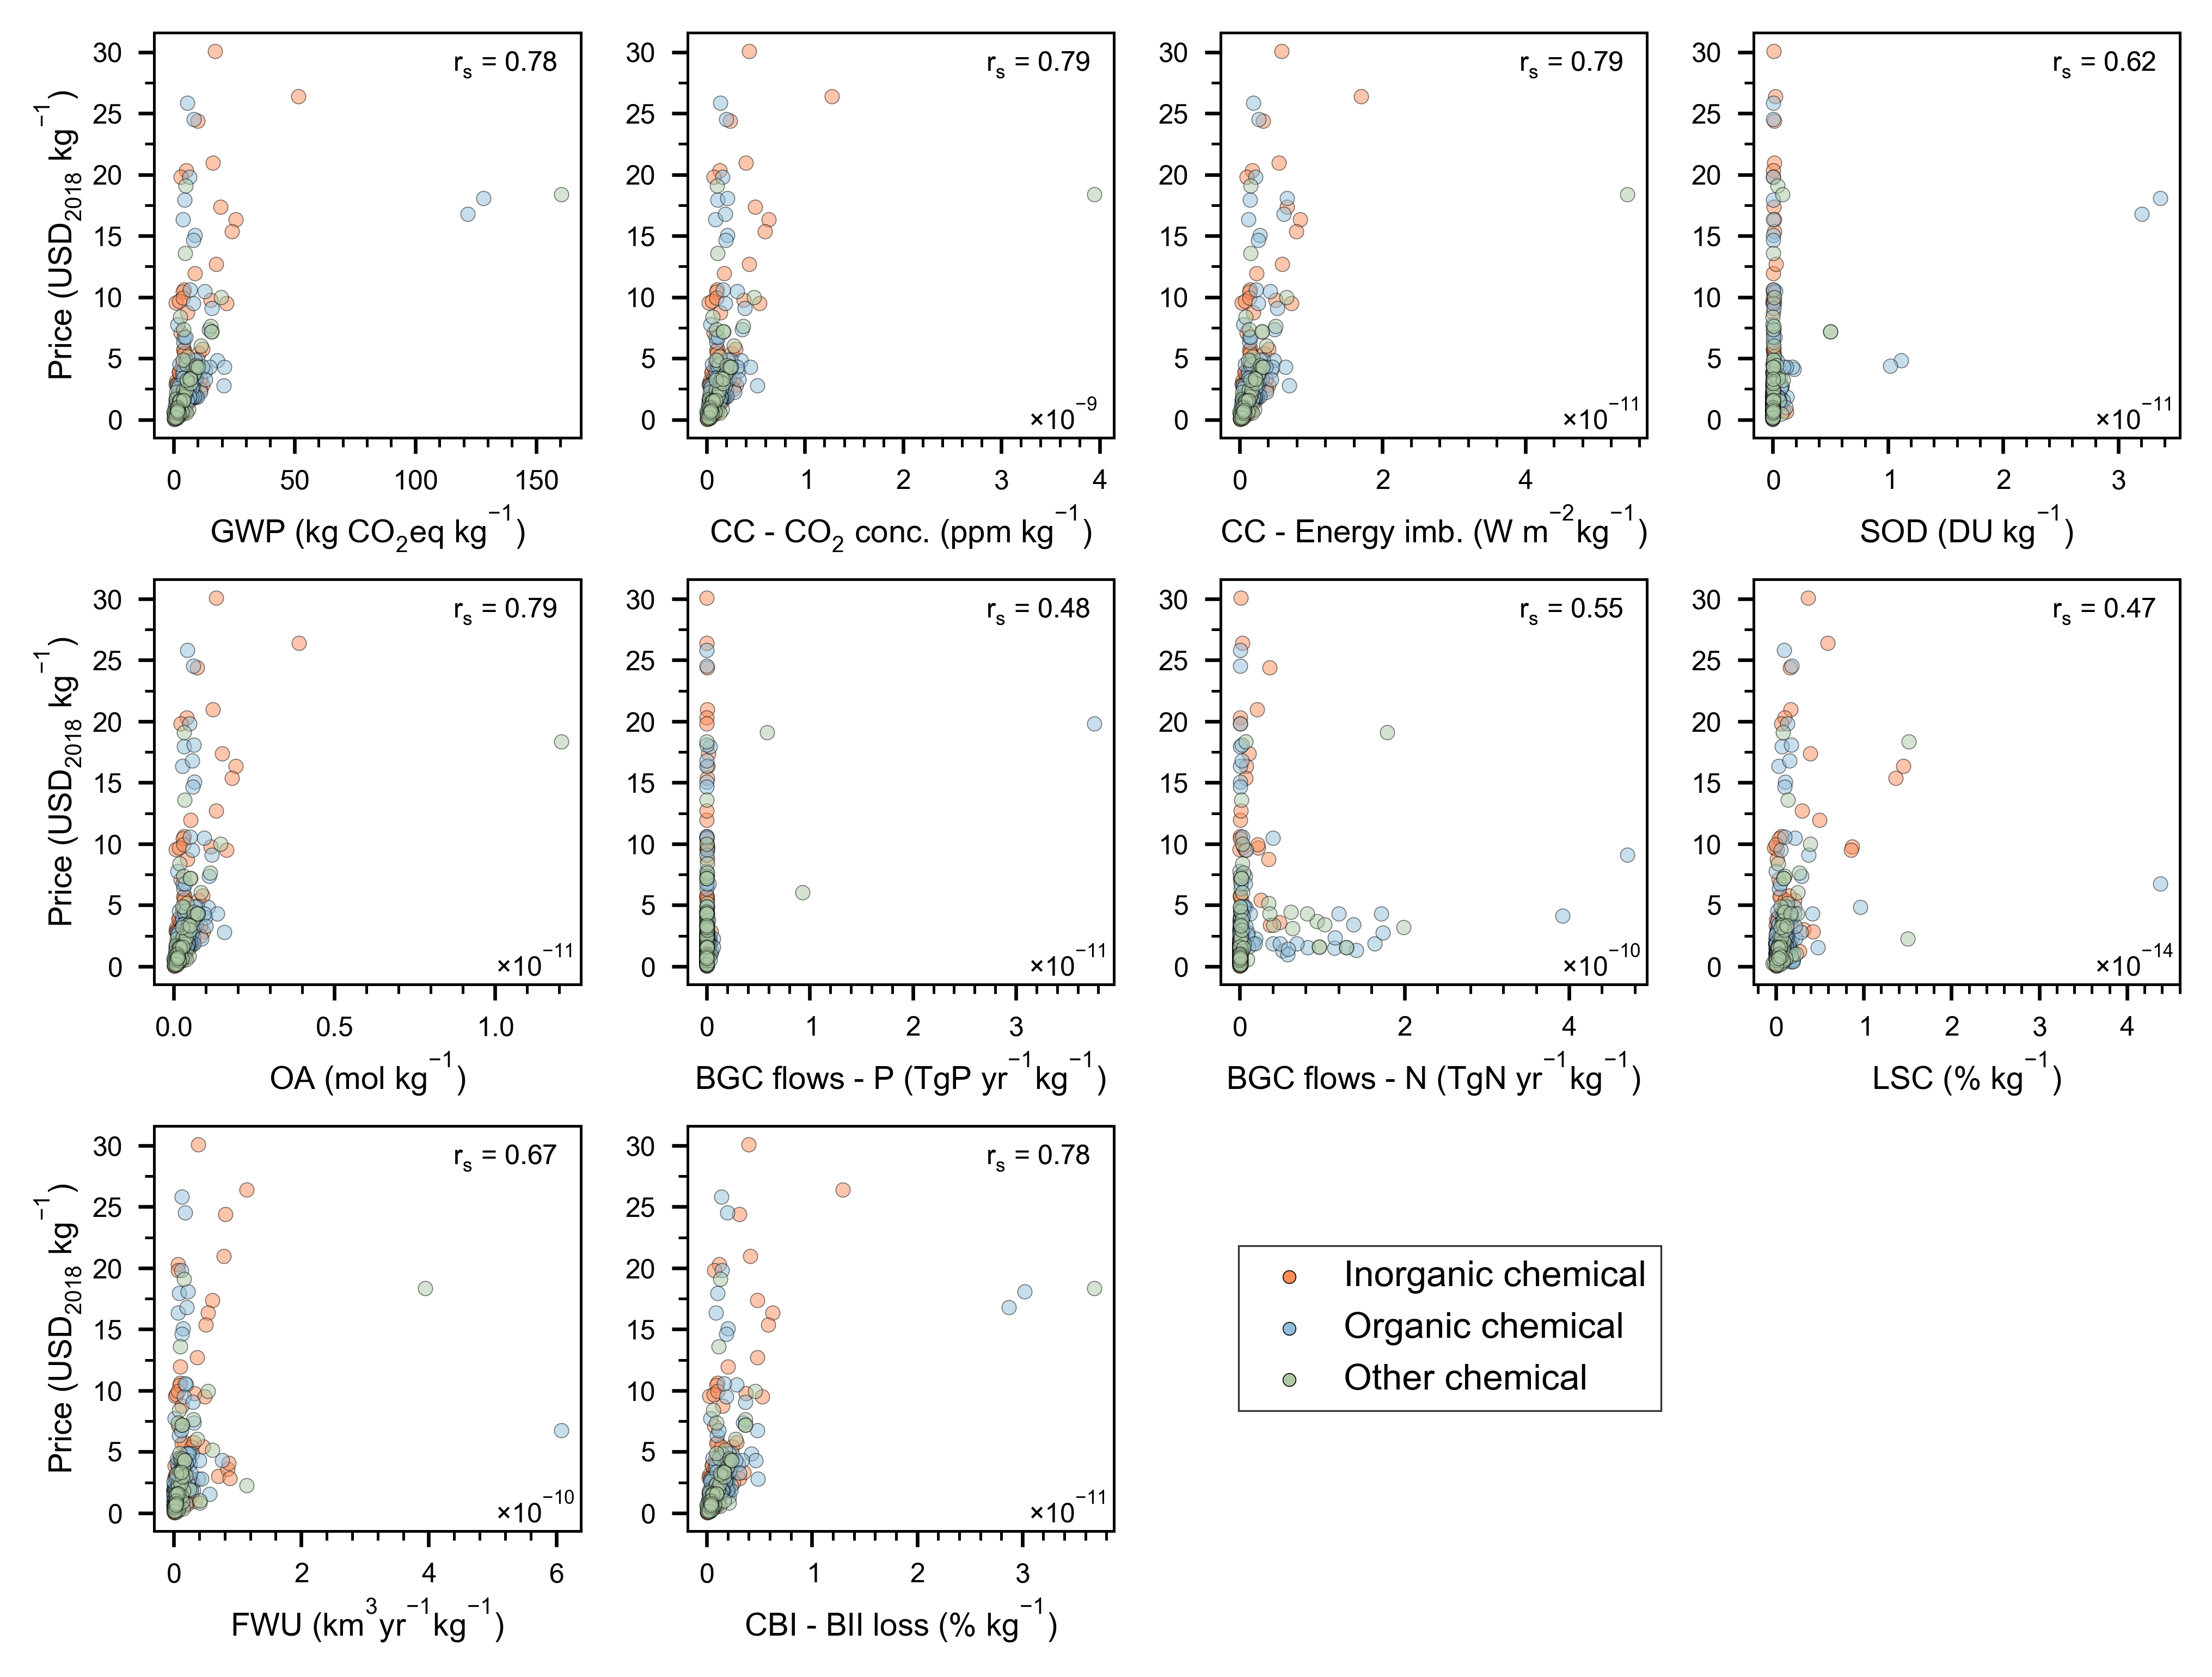

In [132]:
namedf  = "df_base_full_wCAS_woOutliersRMDk9a5"
# namedf  = "df_base_full_wCAS_woOutliersMDk20a5"
# namedf = "df_base_full_wCAS"
loop_methods = lst_methods

# ~~~~ (auto) don't modify ~~~~~~~~~~
df_toplot = pd.eval(namedf)
if any("TL" in i for i in loop_methods):
    dict_pbs_plot = dict_labels_TLs
else:
    dict_pbs_plot = dict_labels_PBs

# ================
# removing rows where GWP > 32
# this df is used only for plotting, not affecting r_spearman, nor r_pearson, nor R^2
# df_toplot_clean = df_toplot[df_toplot[lst_methods[0]] <= 32]
df_toplot_clean = df_toplot[df_toplot.referenceProduct_price < 31] 
# ================

######################

size_legend_font = 8

## personalized legend handler adapted from https://stackoverflow.com/a/57697692/14485040
import string

from matplotlib.legend import Legend
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text


class TextHandlerB(HandlerBase):
    def create_artists(
        self, legend, text, xdescent, ydescent, width, height, fontsize, trans
    ):
        tx = Text(
            width / 2.0,
            height / 2,
            text,
            fontsize=size_legend_font,
            ha="center",
            va="center",
            fontweight="normal",
        )
        return [tx]


Legend.update_default_handler_map({str: TextHandlerB()})
#######################


fig_width, fig_height = 171, 130
fig = create_fig(size_in_mm=(fig_width, fig_height), dpi=600)
# fig.subplots()

# Variables to define figure's empty space from its borders to the spines of the axes
from_left = 11  # in mm  ## approx length to y_spine from the left: length of yticklabels + padding + space to border (2 mm)
from_right = 2.5  # in mm  ## approx length to y_spine from the right: length of yticklabels + padding + space to border (2 mm)
from_bottom = 11  # in mm
from_top = 2.5  # in mm ## approx length to x_spine from the top: length of xticklabels + padding + space to border (2 mm)

# Grid specification (level:0)
gs = fig.add_gridspec(
    nrows=3,
    ncols=4,
    width_ratios=[1, 1, 1, 1],
    height_ratios=[1, 1, 1],
    wspace=0.25,
    hspace=0.35,
    top=1 - from_top / fig_height,
    bottom=from_bottom / fig_height,
    left=from_left / fig_width,
    right=1 - from_right / fig_width,
)

for gsx, cat in enumerate(loop_methods):
    x_raw = df_toplot[cat]
    y_raw = df_toplot.referenceProduct_price
    # Remove Nan values
    mask = ~np.isnan(x_raw) & ~np.isnan(y_raw)
    x = x_raw[mask]
    y = y_raw[mask]
#     y = np.log(y_raw[mask])  # !!! CHANGEd DUE TO set_yscale("log")

    # Linear regression
    (X, Y_pred), Rsquare, _ = linear_regr(x, y)
    
    # Spearman's rank correlation coefficient
    # assesses monotonic relationships between variables
    r_spearman = x.corr(y, method='spearman').round(2)
    r_spearman_text = "$r_{s}$ = " + str(r_spearman)

    # Pearson correlation coefficient
    # assesses linear relationships between variables
    r_pearson = x.corr(y, method='pearson').round(2)
    
    print("r_spearman is {}\nr_pearson is {}".format(r_spearman, r_pearson))
    print(Rsquare)

    # Subplots ....
    ax = fig.add_subplot(gs[gsx])    

    grouped = dict(list(df_toplot_clean.groupby("category_regrouped")))
    tot_keys = len(grouped)

    scplot_list = []  # store PathCollection of each scatter plot
    for i, (key, group) in enumerate(grouped.items()):

        x_group_raw = group[cat]
        y_group_raw = group.referenceProduct_price

        #         size_to_plot = "complexity_norm"
        #         size_to_plot = "MW_norm"
        size_to_plot = "MW"
        if size_to_plot == "complexity_norm":
            s_group_raw = group["complexity_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized compound complexity (%): "
        elif size_to_plot == "MW_norm":
            s_group_raw = group["MW_norm"] * 10  # !!!!!!!!!!!!!!!
            size_label = "Normalized molecular weight (%): "
        elif size_to_plot == "MW":
            s_group_raw = group["MW"] * 0.1  # !!!!!!!!!!!!!!!
            size_label = "Molecular weight (g/mol): "

        # Remove Nan values
        mask_group = ~np.isnan(x_group_raw) & ~np.isnan(y_group_raw)
        x_group = x_group_raw[mask_group]
        y_group = y_group_raw[mask_group]
        s_group = s_group_raw[mask_group]  # !!!!!!!!!!!!!!!
#         print("min size: {}, max size: {}".format(s_group.min(), s_group.max()))

        # ---------- scatter plot ---------------
#         scplot = ax_3.scatter(
        scplot = ax.scatter(
            x=x_group,
            y=y_group,
            c=plot_colors[key],
            #             label=key,
            alpha=0.5,
            s=10, #s_group,  # 4, # !!!!!!!!!!!!!!!
            linewidths=0.2,
            ec="k",
        )
        scplot_list.append(scplot)
        # ---------- r_s value ---------------
        xposR2 = 0.70
        yposR2 = 0.92

        ax.text(
            xposR2,
            yposR2,
#             Rsquare,
            r_spearman_text,
            horizontalalignment="left",
            verticalalignment="center",
            transform=ax.transAxes,
            bbox=dict(
                boxstyle="square,pad=.1", facecolor="white", alpha=0.5, ec="white"
            ),
            #             backgroundcolor="white",
            fontsize=6,
        )
    ax.set_ylabel(ylabel="Price ($USD_{2018}\ kg^{-1}$)", labelpad=2)
#         xlabelname = "\n".join(
#             textwrap.wrap(dict_pbs_plot[cat][0] + " (" + dict_pbs_plot[cat][1] + ")", 50)
#         )
    xlabelname = "\n".join(
        textwrap.wrap(dict_pbs_plot[cat][0] + " ("+ dict_pbs_plot[cat][1] +")", 50)
    )
    ax.set_xlabel(xlabel=xlabelname, labelpad=2)

    xlim_ax = ax.get_xlim()
    ylim_ax = ax.get_ylim()

#     if gsx in [1, 2, 4, 5, 7, 8]:
    if gsx in [1, 2, 3, 5, 6, 7, 9]:
        ax.set_ylabel(None)

    # ~~~~~~~~~~~~  ~~~~~~~~~~~~
    # --- Format the scale of x axis ---
    dict_major_multiplelocators_minorlocators = {0.01: 5, 0.2: 2, 0.5: 5, 1: 5, 2: 4, 5: 5, 10: 5, 20: 4}
    list_of_major_multiplelocators = list(dict_major_multiplelocators_minorlocators.keys())
    axis_range = abs(max(ax.get_xticks())- min(ax.get_xticks()))
    divs = []
    for i in range(4,11): # roughtly the number of majorlocators should be between 4 and 10
        division = axis_range/i
        divs.append(division)

    closest = {}
    for i_n, n in enumerate(divs):
        for i_m, m in enumerate(list_of_major_multiplelocators):
            close = abs(m - n)
            coordinate = (i_n, i_m)
            closest[coordinate] = close
    coord = [k for k,v in closest.items() if min(closest.values()) == v]
    maj_multlocator = list_of_major_multiplelocators[coord[0][1]]
    min_autominlocator = dict_major_multiplelocators_minorlocators[maj_multlocator]
    
    if max(ax.get_xticks()) not in range(1,150): # > 150:
        formatter = ScalarFormatter(useMathText=True)
        formatter.set_scientific(True)
        min_exp = -1  # -1
        max_exp = 3  # 1
        formatter.set_powerlimits((min_exp, max_exp))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_minor_locator(AutoMinorLocator(5))
        # ~~~~ move the formatter inside the axes box
        ## from https://stackoverflow.com/a/59018067/14485040
        ax.get_xaxis().get_offset_text().set_visible(
            False
        )  # .set_position((1.1,0)) # only moves on its x-axis
        ax_max = max(ax.get_xticks())
        exponent_axis = np.floor(np.log10(ax_max)).astype(int)
        if exponent_axis <= min_exp or exponent_axis >= max_exp:
            ax.annotate(
                r"$\times$10$^{%i}$" % (exponent_axis),
                #             xy=(0.76, 0.02),
                xy=(0.8, 0.02),
                xycoords="axes fraction",
                fontsize=6,
            )
    else:
        ax.xaxis.set_major_locator(MultipleLocator(maj_multlocator))
        ax.xaxis.set_minor_locator(AutoMinorLocator(min_autominlocator))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    # ~~~~~~~~~~~~  ~~~~~~~~~~~~

# Legend
# gs_legend = fig.add_subplot(gs[3, :])
# gs_legend = fig.add_subplot(gs_null[1])
gs_legend = fig.add_subplot(gs[2, 2:])
gs_legend.axis("off")

# size of the bubbles
# taken from https://stackoverflow.com/a/58485655/14485040
# and here https://matplotlib.org/stable/api/collections_api.html#matplotlib.collections.PathCollection.legend_elements

# ####
# getting from the last subplot the category with the largest range size
# ideally the largest range size will contain the exact values
# which I want to show in the legend (the ones in sizes_on_legend) - make sure this is true
# range_size_dict = dict()
# for p in scplot_list:
#     range_size = p.get_sizes().max() - p.get_sizes().min()
#     range_size_dict[p] = range_size
# max_range_size = max(range_size_dict.values())
# scplot = [k for k, v in range_size_dict.items() if v == max_range_size][
#     0
# ]  # getting the PathCollection with the largest range size
# # ####
# sizes_on_legend = [5, 30, 60, 90]  # they have to be divided by 0.1
# handles_size, labels_size = scplot.legend_elements("sizes", num=sizes_on_legend)
# labels_size = [int(i / 0.1) for i in sizes_on_legend]

# the other items of the legend
for key, group in grouped.items():
    ax.scatter(
        [],
        [],
        color=plot_colors[key],
        label=key,
        marker="o",
        s=8,
        linewidths=0.2,
        ec="k",
    )
handles_other, labels_other = ax.get_legend_handles_labels()

# Number of colums in the legend
ncolumns_legend = 3

if ncolumns_legend == 2:
    handles, labels = handles_other + handles_size, labels_other + labels_size
elif ncolumns_legend == 3:
    handles, labels = (
        handles_other,# + handles_size + handles_hp,
        labels_other,# + labels_size + labels_hp,
    )
#     extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
else:
    handles, labels = handles_size + handles_other, labels_size + labels_other


leg = gs_legend.legend(
    handles,
    labels,
    frameon=True,
    loc="center left",
    bbox_to_anchor=(0.0, 0.5),
    ncol=1, #ncolumns_legend,  # see above
    fontsize=size_legend_font,
    fancybox=False,
    handletextpad=0.5,
    columnspacing=0.7,
    edgecolor="k",
)
leg.get_frame().set_linewidth(0.4)

### EXPORT FIGURE
figNamePNG = "Fig_ESI-Prices-vs-PBs-and-GWP-{}.png".format(namedf)
figNameSVG = "Fig_ESI-Prices-vs-PBs-and-GWP-{}.svg".format(namedf)

plt.savefig(str(pngFilesDir / figNamePNG))  # export fig as png
plt.savefig(str(svgFilesDir / figNameSVG))  # export fig as svg

In [167]:
# LIST OF CHEMICALS NOT SHOWN ON previous figure DUE TO HIGH Prices...
# this list or graphical representation will be shown in ESI?

df_not_on_figprices = df_base_full_wCAS_woOutliersRMDk9a5[
    df_base_full_wCAS_woOutliersRMDk9a5.referenceProduct_price >= 31
].sort_values(
    by=[
        "referenceProduct_price",
#         "('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')",
    ]
)[
    lst_metadata[0:1]
    + lst_metadata[4:5]
    + ["referenceProduct_price"]
    + lst_methods  # [0:1]
    #     + lst_methods_TLs
]  # .shape
# df_not_on_figprices

In [168]:
%%time

# Set output directory
outputs_dir = set_outputs_dir(use_default=True)  # default `..\data\interim`

## Export dataframe to excel
excelName = "list-chemicals-not-shown-on-fig-prices-vs-impacts.xlsx"

df_readme = make_readme_info(
    excelName,
    "Sheet1: Dataframe of chemicals excluded from Fig 'Prices vs Impacts PB and GWP' "
    "with their prices, GWP and PBs scores"
    "\n[none of the chemicals in the list were detected as outliers, but"
    " were omitted in fig for visualisation purposes]",
)

w_excel(
    path_to_file=outputs_dir,
    filename=excelName,
    dict_data_to_write={
        "Sheet1": df_not_on_figprices,
    },
    readme_info=("readme", df_readme),
    #     ExcelWriter_kwargs={"engine": "openpyxl", "encoding": "UTF-8"}
    #     startrow=0
)

File: list-chemicals-not-shown-on-fig-prices-vs-impacts.xlsx successfully created in 
C:\Users\ViteksPC\Documents\00-ETH_projects\17-LCIA_methods_analysis\data\interim
Wall time: 147 ms


### fig (sustainable chemicals!)

In [109]:
# dict_pbs

In [124]:
TLs_base = calculate_TL_PBs(
    df_base, method_labels=list(dict_pbs.keys()), correctGVA="purchases"
)
# TLs_base

df_TLs_base = pd.concat(
    [
        df_base.loc[TLs_base.index][lst_metadata],
        df_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"],
        TLs_base,
    ],
    axis=1,
)
df_TLs_base.sample(2)

Activity   category_regrouped  \
154   Cadmium telluride, semiconductor-grade {GLO}| ...  34: Basic chemicals   
1085  Pitch despergents, in paper production, combin...  34: Basic chemicals   

                                       activity_comment      type  \
154   Production volume: 10094.5772307692 kgInclu...  Products   
1085                                               None  Products   

                            referenceProduct                    category  \
154   Cadmium telluride, semiconductor-grade  Chemicals\Inorganic\Market   
1085  Pitch despergents, in paper production     Chemicals\Others\Market   

                                    inline_comment  geo  \
154   Production Volume Amount: 10094.5772307692  GLO   
1085                                          None  GLO   

                       activity_ISICclass activity_ecoSpold01class  \
154   2011:Manufacture of basic chemicals        metals/extraction   
1085  2011:Manufacture of basic chemicals                      NaN   

      technologyLevel  referenceProductAmount referenceProductUnit  \
154               0.0                       1                   kg   
1085              NaN                       1                   kg   

      referenceProduct_prodVolume referenceProduct_prodVolumeComment  \
154                  10094.577231                                NaN   
1085                     4.000000                               None   

      referenceProduct_price referenceProduct_priceUnit  \
154                    14.60                    EUR2005   
1085                    0.86                    EUR2005   

                          referenceProduct_priceComment  \
154   Calculated based on inputs: The price of the p...   
1085                                               None   

     referenceProduct_casNumber              referenceProduct_CPCclass  \
154                   1306-25-8  342: Basic inorganic chemicals n.e.c.   
1085                        NaN                    34: Basic chemicals   

                                activity_generalComment  \
154                                                 NaN   
1085  Combined activity, mass allocated from RER, Ro...   

                                         sourceFilename pubchem_match  \
154   20843_e18cd1f7-73a7-45b6-a439-d4808b39ec60_7ef...        by CAS   
1085                                               None      No match   

      num_matches    MF     MW                 iupac  complexity  \
154             1  CdTe  240.0  tellanylidenecadmium         2.0   
1085            0   NaN    NaN                   NaN         NaN   

                                               synonyms  \
154   ['Cadmium telluride', '1306-25-8', 'Cadmium te...   
1085                                                NaN   

      ('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')  \
154                                           16.171057            
1085                                           1.225988            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')  \
154                                            7.019480                            
1085                                           9.024679                            

      ('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')  \
154                                            6.938388                            
1085                                           8.626686                            

      ('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')  \
154                                            0.011108                      
1085                                           0.002578                      

      ('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')  \
154                                            2.238233                      
1085                                           2.877618                      

      ('PBs

In [111]:
# df_TLs_base.columns

(-1.0, 2.0)

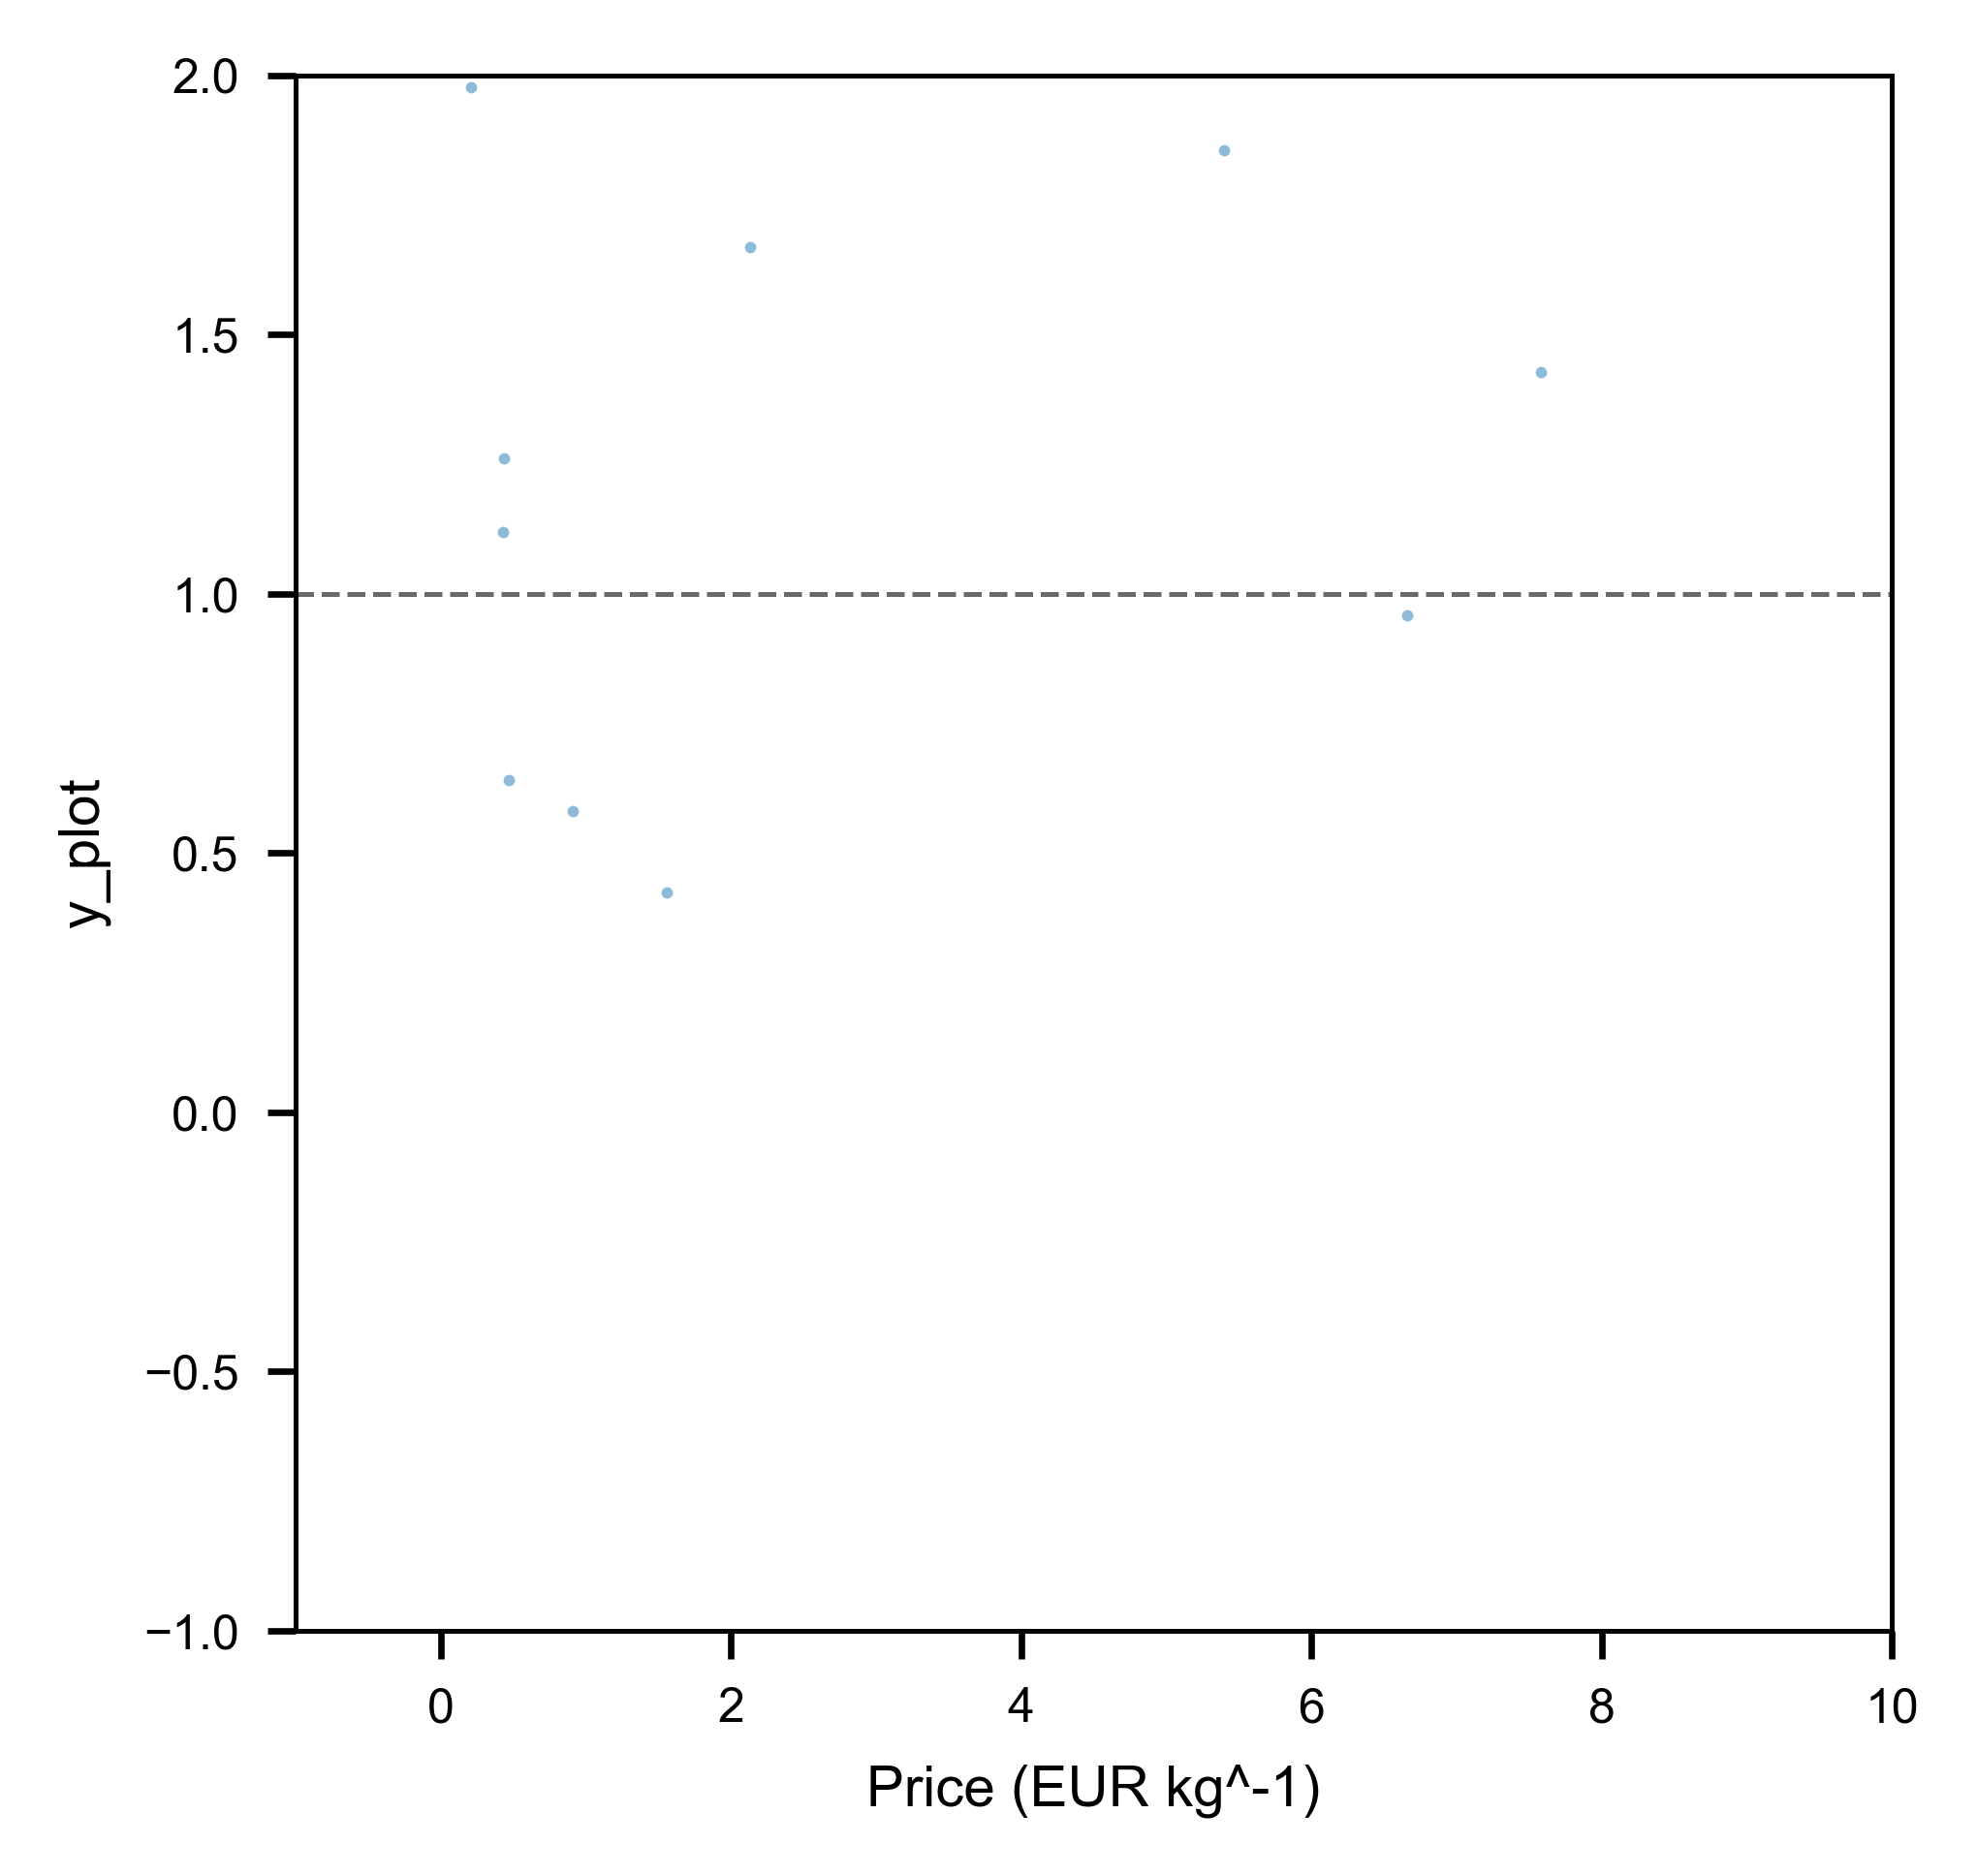

In [125]:
x_plot = df_TLs_base.referenceProduct_price
# y_plot = df_TLs_base["('IPCC 2013 GWP 100a V1.03', 'IPCC GWP 100a', 'kg CO2 eq')"]
y_plot = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"]
# y_plot = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"]


fig = create_fig((90,90))

ax = fig.subplots()
ax.scatter(x=x_plot,y=y_plot, s=2, alpha=0.5, lw=0)
ax.set_xlabel("Price (EUR kg^-1)")
ax.set_ylabel("y_plot")
ax.axhline(1, color="dimgray", linestyle="--", linewidth=0.6,)
ax.set_xlim(left=-1, right=10)
ax.set_ylim(bottom=-1, top=2)

In [95]:
# cat = "('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"
# df_TLs_base[(df_TLs_base.amount_price < 10) & (df_TLs_base[cat] < 1)]

In [126]:
# Find chemicals with absolute sustainability

c0 = df_TLs_base.referenceProduct_price < 10
c1 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - CO2 concentration', 'ppm')"]<= 1)
c2 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Climate change - Energy imbalance', 'Wm-2')"]<= 1)
c3 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Stratospheric ozone depletion', 'DU')"]<= 1)
c4 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Ocean acidification', 'Omega Aragon')"]<= 1)
c5 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - P', 'Tg P')"] <= 1)
c6 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Biogeochemical flows - N', 'Tg N')"] <= 1)
c7 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Land-system change - Global', '%')"] <= 1)
c8 = df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Freshwater use - Global', 'km3')"] <= 1
c9 = (df_TLs_base["('PBs-LCIA (baseline) V0.72', 'Change in biosphere integrity - BII loss', '% BII loss')"]<= 1 )

df_TLs_base[conjunction(
#     c0, 
    c1, 
    c2, 
    c3, 
    c4, 
    c5, 
    c6, 
    c7, 
    c8, 
    c9
)]

NameError: name 'conjunction' is not defined

### fig ESI (heatmaps correlations)

In [144]:
def calc_Pearson_Spearman_Plot (df_data, methods_1, methods_2,
                                annotations=True, 
#                                 pairplot=False, 
#                                 pp_xvars=data.columns.values.tolist(), 
#                                 pp_yvars=data.columns.values.tolist(),
                               ):
    """Calculate Pearson product moment correlation and Spearman rank-order correlation,
        Plot the correlations on a heatmap and optionally, plot a pairplot of the data
        
        Pearson coefficient: measure of linear correlation between two sets of data
                            https://www.wikiwand.com/en/Pearson_correlation_coefficient
        Spearman coefficient: a nonparametric measure of rank correlation 
                            (statistical dependence between the rankings of two variables). 
                            It assesses how well the relationship between two variables 
                            can be described using a monotonic function.    
                            https://www.wikiwand.com/en/Spearman%27s_rank_correlation_coefficient
        
        
        """
    
    size_in_mm = (150,150) # size of the plots
    
    col_label_name_1 = methods_1
    col_label_name_2 = methods_2
    
    data_1 = df_data[col_label_name_1]
    data_2 = df_data[col_label_name_2]
    data = pd.concat([data_1, data_2], axis=1)
    
#     data_1 = df_data[method_1][np.array(categories_1)]
#     data_2 = df_data[method_2][np.array(categories_2)]
#     data = pd.concat([data_1, data_2], axis=1)
    
    fig = create_fig((200, 200), 150)
    ax1 = fig.subplots(1,1)
#     if pairplot == True:
#         sns.pairplot(data, 
#                      x_vars=pp_xvars,
#                      y_vars=pp_yvars,
# #                      corner=True # triangulize
#                     );
#         pairplot_of_data = sns.pairplot(data);
#     else:
#         pairplot_of_data = 'Pairplot not plotted.'
    # ---------------------------------------
    
    # Pearson correlation:
    pearson_corr = data.corr(method='pearson')
    
    # Spearman correlation:
    spearman_corr = data.corr(method='spearman')
    
    # Plot the whole heatmap:
#     fig, axes = plt.subplots(nrows=1, ncols=1, 
#                            figsize=[x/25.4 for x in size_in_mm],
#                            dpi=75, sharey=False,
#                             )
#     axes = sns.heatmap(pearson_corr,
#                        annot=annotations,
#                        linewidths=0.05,
#                        center=1,
#                        cmap='YlGnBu'
#                       )

    # Triangulize the heatmap, show anly lower part:
    mask1 = np.zeros_like(pearson_corr)
    mask1[np.triu_indices_from(mask1)] = True
    with sns.axes_style("white"):
#         fig, axes = plt.subplots(nrows=1, ncols=1,
#                                  figsize=[x/25.4 for x in size_in_mm],
#                                  dpi=75, sharey=False,
#                                 )
#         axes1 = 
        axes = sns.heatmap(pearson_corr,
                           mask=mask1,
                           square=True, 
                           annot=annotations,
                           annot_kws={"size":6}, 
                           linewidths=0.05, 
                           center=1,
                           cmap='YlGnBu',
#                             ax=ax1
                          )
#     axes1.set_title('Pearson correlation', fontsize=15)       
    # ---------------------------------------

    
    # Plot the whole heatmap:    
#     fig, axes = plt.subplots(nrows=1, ncols=1, 
#                              figsize=[x/25.4 for x in size_in_mm],
#                              dpi=75, sharey=False,
#                             )
#     axes = sns.heatmap(spearman_corr,
#                        annot=annotations,
#                        linewidths=0.05,
#                        center=1,
#                        cmap='YlOrRd'
#                       )

    # Triangulize the heatmap, show anly UPPER part:
    mask2 = np.zeros_like(spearman_corr)
    mask2[np.tril_indices_from(mask2)] = True
    with sns.axes_style("white"):
#         fig, axes = plt.subplots(nrows=1, ncols=2,
#                                  figsize=[x/25.4 for x in size_in_mm],
#                                  dpi=75, sharey=False,
#                                 )
#         axes2 = 
        axes = sns.heatmap(spearman_corr,
                           mask=mask2,
                           square=True, 
                           annot=annotations, 
                           annot_kws={"size":6}, 
                           linewidths=0.05, 
                           center=1,
                           cmap='YlOrRd',
#                             ax=ax1
                          )
#     axes2.set_title('Spearman correlation', fontsize=15)
    axes.set_title('Correlations: LTM - Pearson/ UTM - Spearman', fontsize=9)
    
#     return pairplot_of_data

In [98]:
# df_clean.columns

In [262]:
# df_base_full_wCAS_woOutliers[lst_methods[0:1] + lst_methods_TLs].corr(method='pearson')

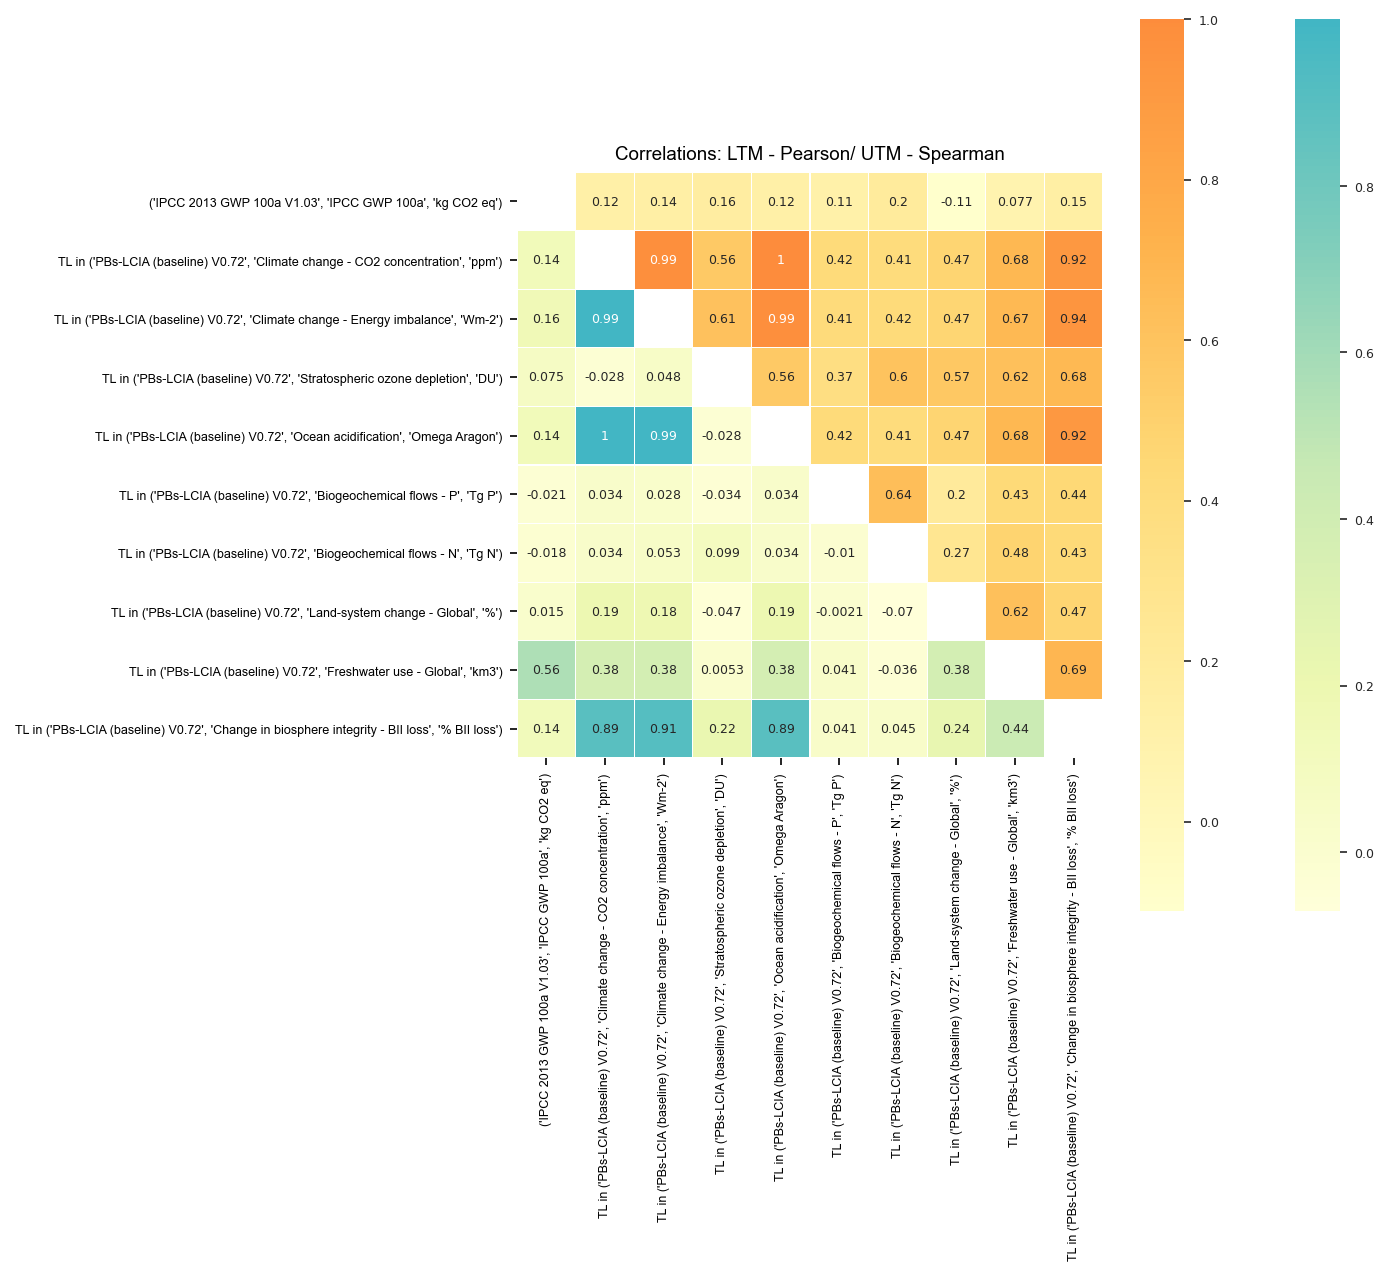

In [145]:
# calc_Pearson_Spearman_Plot(df_clean, lst_methods, [], annotations=False)
# calc_Pearson_Spearman_Plot(df_clean, lst_methods, ["complexity"])
calc_Pearson_Spearman_Plot(
    df_base_full_wCAS_woOutliersRMDk9a5,
#     df_base_full_wCAS_woOutliersMDk20a5,
    lst_methods[0:1], 
#     lst_methods[1:] ,
    lst_methods_TLs,
#     ["referenceProduct_price", "referenceProduct_prodVolume"] +lst_methods ,
#     ["complexity", "MW"], 
    annotations=True
)

In [146]:
dict_per_chemical = dict(list(df_clean.groupby(by="category_regrouped")))

for key in dict_per_chemical:
    calc_Pearson_Spearman_Plot(
        dict_per_chemical[key],
        ["referenceProduct_price", "referenceProduct_prodVolume"] +lst_methods ,
        ["complexity", "MW"], 
        annotations=True
    )
    print(key)

NameError: name 'df_clean' is not defined